### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# vgg-nets

*Author: Pytorch Team*

**Award winning ConvNets from 2014 Imagenet ILSVRC challenge**

<img src="https://pytorch.org/assets/images/vgg.png" alt="alt" width="50%"/>

All pre-trained models expect input images normalized in the same way,
i.e. mini-batches of 3-channel RGB images of shape `(3 x H x W)`, where `H` and `W` are expected to be at least `224`.
The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]`
and `std = [0.229, 0.224, 0.225]`.

Here's a sample execution.

# Models

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

import time
import math
import copy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg11', pretrained=False)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg11_bn', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg13', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg13_bn', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg16', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg16_bn', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg19', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg19_bn', pretrained=True)

#print(model)

In [3]:
class Conv(nn.Module):
    def __init__(
        self,
        conv,
        output_C=None
    ):
        super().__init__()
        self.conv = conv
        self.output_C = output_C

    def forward(self, x):
        B,T,C = x.shape
        x = x.unsqueeze(1)
        x = self.conv(x)
        if self.output_C is None:
            self.output_C = C
        x = x.reshape(B, -1, self.output_C)
        x = x.prod(-1).sum(-1)
        return x


In [4]:
class Smartpool(nn.Module):
    def __init__(
        self,
        factor,
        search_perc,
        mlp2=False
    ):
        """Smart pooling algorithm

        Args:
            factor: factor by which the sequence's length will be reduced
            search_perc: percentage of length of sequence after smartpooling to search for border. Ideally the border is located somewhere in +-search_perc
        """
        super().__init__()

        self.search_perc = search_perc
        self.factor = factor
        self.register_buffer("filters", torch.FloatTensor([[[[-1,1],[1,-1]]]]), persistent=False)
        self.mlp = nn.Sequential(
            nn.Linear(2, 256),
            nn.Dropout(0.1),
            nn.GELU(),
            nn.Linear(256,512),
            nn.Dropout(0.1),
            nn.GELU(),
            nn.Linear(512,256),
            nn.Dropout(0.1),
            nn.GELU(),
            nn.Linear(256,1),
            nn.Sigmoid())
        
        if mlp2 == True:
            self.mlp2 = nn.Sequential(
                nn.Linear(2, 256),
                nn.Dropout(0.1),
                nn.GELU(),
                nn.Linear(256,512),
                nn.Dropout(0.1),
                nn.GELU(),
                nn.Linear(512,256),
                nn.Dropout(0.1),
                nn.GELU(),
                nn.Linear(256,1))
        else:
            self.mlp2 = None

    def warp(self, X, new_lens):
        new_lens_cs = new_lens.cumsum(1)
        # This really searches for the low boundary of each new pixel
        pixel_contributions = new_lens_cs.view(1, -1, 1) - torch.arange(torch.round(new_lens_cs[0, -1]).item(), device=X.device).view(1, 1, -1)
        pixel_contributions = pixel_contributions.view(X.size(0), X.size(1), pixel_contributions.size(2))
        # Zero out the negative contributions, i.e. pixels which come before each row                              
        pixel_contributions = torch.max(torch.tensor(0.0, device=X.device), pixel_contributions)       
        
        # # This contains the cumulated pixel lengths for all pixels in each 
        # pixel_contributions
    
        pixel_contributions = pixel_contributions.unsqueeze(1)
        interp_weights = F.conv2d(pixel_contributions, self.filters, padding=1)
        interp_weights = interp_weights[:,:,:-1,1:] # Removing padding
        interp_weights = interp_weights.squeeze(1)

        # # Each column corresponds to a new element. Its values are the 
        # # weights associated with the original data.
        # interp_weights

        interp_weights = interp_weights.transpose(1, 2)
        Xnew = interp_weights @ X
        return Xnew, interp_weights

    def nonzero_interval_length(self, x, dim):
        nonz = (x > 0)
        _, low = ((nonz.cumsum(dim) == 1) & nonz).max(dim, keepdim=True)
        rev_cumsum = nonz.long().flip(dim).cumsum(dim).flip(dim)
        _, high = ((rev_cumsum == 1) & nonz).max(dim, keepdim=True)
        
        return high - low + 1

    def forward(self, features):
        B,T,C = features.size()

        padding_mask = torch.zeros(B,T, dtype=torch.bool, device=features.device)
        padding_per_batch = (padding_mask > 0).sum(1)
        total_T = padding_mask.numel() - padding_per_batch.sum()

        # MLP test
        new_lens = self.mlp(features.view(B*T,C)).view(1,-1)
        new_lens = new_lens / new_lens.sum(1, keepdim=True) * (total_T / self.factor) # Reducing the original length T by some factor
       
        features, interp_weights = self.warp(features, new_lens)
        
        if self.mlp2 is not None:
            features = self.mlp2(features)

        return features
        

class DoXTimes(nn.Module):
    def __init__(self, model):
         super().__init__()
         self.model = model

    def forward(self, x): 
        return torch.cat([self.model(x[i].unsqueeze(0)) for i in range(x.shape[0])]).prod(-1).sum(-1)

# Task code

In [5]:
def get_batch(batch_size, seq_len, divider):
    assert seq_len % divider == 0
    data = torch.empty(batch_size, seq_len, 2)
    data[:,:,0] = torch.zeros_like(data[:,:,0])
    batch_id = torch.arange(batch_size).view(-1,1)
    data[batch_id, torch.multinomial(torch.ones_like(data[:,:,0]), seq_len//divider), 0] = 1
    data[:,:,1].uniform_(0,1)
    return data


In [6]:
def train(model, epoch, optimizer, scheduler, dataset_len, batch_size, seq_len, divider):
    model.train()
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, dataset_len, batch_size)):
        data = get_batch(batch_size, seq_len, divider).to(device)
        targets = data.prod(-1).sum(-1)
        optimizer.zero_grad()
        output = model(data)
        
        loss = (1 - output / targets).abs().mean()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            """
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, dataset_len // batch_size, scheduler.get_last_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            """
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} |'.format(
                    epoch, batch, dataset_len // batch_size, scheduler.get_last_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()

In [7]:
def evaluate(model, dataset_len, batch_size, seq_len, divider):
    model.eval()
    total_loss = 0.
    with torch.no_grad():
        for i in range(0, dataset_len, batch_size):
            data = get_batch(batch_size, seq_len, divider).to(device)
            targets = data.prod(-1).sum(-1)
            output = model(data)
            total_loss += (1 - output / targets).abs().mean().item()
    return total_loss / (dataset_len / batch_size)

In [42]:
def train_model(model, epochs, batch_size, eval_batch_size, dataset_len, seq_len, divider, optimizer, scheduler):
    best_val_loss = float("inf")
    best_model = None

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train(model, epoch, optimizer, scheduler, dataset_len, batch_size, seq_len, divider)
        val_loss = evaluate(model, dataset_len, eval_batch_size, seq_len, divider)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
            'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                        val_loss, math.exp(val_loss)))
        print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)

        scheduler.step()


    test_loss = evaluate(best_model, dataset_len, eval_batch_size, seq_len, divider)
    print('=' * 89)
    print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
        test_loss, math.exp(test_loss)))
    print('=' * 89)

    return best_model

# To 2 rows

## Pooling T/4

### Average pooling

In [13]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg11', pretrained=False)
model = model.features[0:9]
model[0] = nn.Conv2d(1, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model[2] = nn.AvgPool2d(kernel_size=2, stride=(2,1), padding=(0,1))
model[5] = nn.AvgPool2d(kernel_size=2, stride=(2,1), padding=0)
model[8] = nn.Conv2d(256, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model.add_module("linear", nn.Conv2d(256, 1, kernel_size=1, stride=1, padding=0))
model = Conv(model)
model = model.to(device)
print(model)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /home/i273233/.cache/torch/hub/v0.6.0.zip


Conv(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): AvgPool2d(kernel_size=2, stride=(2, 1), padding=(0, 1))
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): AvgPool2d(kernel_size=2, stride=(2, 1), padding=0)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (linear): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)


In [14]:
batch_size = 20
eval_batch_size = 10
seq_len = 1000
divider = 4
dataset_len = 100000
lr = 1.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
epochs = 5 # The number of epochs

model = train_model(model, epochs, batch_size, eval_batch_size, dataset_len, seq_len, divider, optimizer, scheduler)



| epoch   1 |   200/ 5000 batches | lr 1.00 | ms/batch 37.01 | loss  0.95 |
| epoch   1 |   400/ 5000 batches | lr 1.00 | ms/batch 34.65 | loss  0.93 |
| epoch   1 |   600/ 5000 batches | lr 1.00 | ms/batch 34.81 | loss  0.93 |
| epoch   1 |   800/ 5000 batches | lr 1.00 | ms/batch 34.85 | loss  0.93 |
| epoch   1 |  1000/ 5000 batches | lr 1.00 | ms/batch 34.90 | loss  0.93 |
| epoch   1 |  1200/ 5000 batches | lr 1.00 | ms/batch 34.92 | loss  0.93 |
| epoch   1 |  1400/ 5000 batches | lr 1.00 | ms/batch 34.96 | loss  0.93 |
| epoch   1 |  1600/ 5000 batches | lr 1.00 | ms/batch 35.12 | loss  0.93 |
| epoch   1 |  1800/ 5000 batches | lr 1.00 | ms/batch 35.17 | loss  0.93 |
| epoch   1 |  2000/ 5000 batches | lr 1.00 | ms/batch 35.18 | loss  0.93 |
| epoch   1 |  2200/ 5000 batches | lr 1.00 | ms/batch 35.25 | loss  0.93 |
| epoch   1 |  2400/ 5000 batches | lr 1.00 | ms/batch 35.25 | loss  0.93 |
| epoch   1 |  2600/ 5000 batches | lr 1.00 | ms/batch 35.28 | loss  0.93 |
| epoch   1 

In [15]:
model.eval()
with torch.no_grad():
    data = get_batch(eval_batch_size, seq_len, divider).to(device)
    targets = data.prod(-1).sum(-1).squeeze(-1)
    output = model(data)
    print('data[0]:', data[0,:50,:])

    print('output:', output)
    print('targets:', targets)

data[0]: tensor([[0.0000e+00, 1.9316e-01],
        [0.0000e+00, 1.2288e-01],
        [1.0000e+00, 8.2184e-01],
        [0.0000e+00, 2.9088e-01],
        [0.0000e+00, 8.8348e-01],
        [0.0000e+00, 4.2186e-01],
        [1.0000e+00, 9.7892e-01],
        [0.0000e+00, 3.2873e-01],
        [0.0000e+00, 9.8628e-04],
        [0.0000e+00, 3.1622e-01],
        [0.0000e+00, 2.9373e-01],
        [0.0000e+00, 7.7972e-01],
        [0.0000e+00, 4.7035e-01],
        [0.0000e+00, 1.2425e-01],
        [0.0000e+00, 3.3145e-01],
        [0.0000e+00, 5.1976e-02],
        [0.0000e+00, 5.1003e-01],
        [0.0000e+00, 1.6871e-01],
        [1.0000e+00, 7.8025e-01],
        [0.0000e+00, 9.3069e-01],
        [1.0000e+00, 8.0811e-01],
        [0.0000e+00, 3.9422e-01],
        [1.0000e+00, 9.8349e-01],
        [1.0000e+00, 7.3919e-01],
        [0.0000e+00, 3.6395e-01],
        [1.0000e+00, 1.2754e-01],
        [0.0000e+00, 7.2988e-01],
        [0.0000e+00, 9.3250e-01],
        [0.0000e+00, 9.5595e-02],
     

### Max pooling

In [16]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg11', pretrained=False)
model = model.features[0:9]
model[0] = nn.Conv2d(1, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model[2] = nn.MaxPool2d(kernel_size=2, stride=(2,1), padding=(0,1))
model[5] = nn.MaxPool2d(kernel_size=2, stride=(2,1), padding=0)
model[8] = nn.Conv2d(256, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model.add_module("linear", nn.Conv2d(256, 1, kernel_size=1, stride=1, padding=0))
model = Conv(model)
model = model.to(device)
print(model)

Using cache found in /home/i273233/.cache/torch/hub/pytorch_vision_v0.6.0


Conv(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (linear): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)


In [17]:
batch_size = 20
eval_batch_size = 10
seq_len = 1000
divider = 4
dataset_len = 100000
lr = 1.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
epochs = 5 # The number of epochs

model = train_model(model, epochs, batch_size, eval_batch_size, dataset_len, seq_len, divider, optimizer, scheduler)


| epoch   1 |   200/ 5000 batches | lr 1.00 | ms/batch 37.73 | loss  0.67 |
| epoch   1 |   400/ 5000 batches | lr 1.00 | ms/batch 37.67 | loss  0.48 |
| epoch   1 |   600/ 5000 batches | lr 1.00 | ms/batch 37.69 | loss  0.48 |
| epoch   1 |   800/ 5000 batches | lr 1.00 | ms/batch 37.69 | loss  0.48 |
| epoch   1 |  1000/ 5000 batches | lr 1.00 | ms/batch 37.69 | loss  0.48 |
| epoch   1 |  1200/ 5000 batches | lr 1.00 | ms/batch 37.68 | loss  0.48 |
| epoch   1 |  1400/ 5000 batches | lr 1.00 | ms/batch 37.71 | loss  0.48 |
| epoch   1 |  1600/ 5000 batches | lr 1.00 | ms/batch 37.68 | loss  0.48 |
| epoch   1 |  1800/ 5000 batches | lr 1.00 | ms/batch 37.67 | loss  0.48 |
| epoch   1 |  2000/ 5000 batches | lr 1.00 | ms/batch 37.68 | loss  0.48 |
| epoch   1 |  2200/ 5000 batches | lr 1.00 | ms/batch 37.69 | loss  0.48 |
| epoch   1 |  2400/ 5000 batches | lr 1.00 | ms/batch 37.69 | loss  0.47 |
| epoch   1 |  2600/ 5000 batches | lr 1.00 | ms/batch 37.68 | loss  0.48 |
| epoch   1 

In [18]:
model.eval()
with torch.no_grad():
    data = get_batch(eval_batch_size, seq_len, divider).to(device)
    targets = data.prod(-1).sum(-1).squeeze(-1)
    output = model(data)
    print('data[0]:', data[0,:50,:])

    print('output:', output)
    print('targets:', targets)

data[0]: tensor([[0.0000, 0.5144],
        [0.0000, 0.4849],
        [0.0000, 0.8429],
        [1.0000, 0.5824],
        [0.0000, 0.7493],
        [0.0000, 0.3822],
        [0.0000, 0.3252],
        [0.0000, 0.6235],
        [1.0000, 0.2795],
        [1.0000, 0.5185],
        [0.0000, 0.1497],
        [1.0000, 0.9238],
        [0.0000, 0.4850],
        [1.0000, 0.8176],
        [1.0000, 0.3368],
        [0.0000, 0.5251],
        [0.0000, 0.0786],
        [0.0000, 0.8424],
        [0.0000, 0.7199],
        [0.0000, 0.9394],
        [0.0000, 0.0350],
        [0.0000, 0.5511],
        [0.0000, 0.0335],
        [0.0000, 0.6633],
        [0.0000, 0.2322],
        [0.0000, 0.6020],
        [1.0000, 0.5486],
        [0.0000, 0.9701],
        [1.0000, 0.8008],
        [0.0000, 0.0352],
        [0.0000, 0.8791],
        [1.0000, 0.2091],
        [0.0000, 0.9137],
        [0.0000, 0.7905],
        [0.0000, 0.7517],
        [1.0000, 0.0346],
        [0.0000, 0.0902],
        [0.0000, 0.9536],
   

### Smart pooling

In [19]:
batch_size = 20
eval_batch_size = 10
seq_len = 1000
divider = 4
dataset_len = 100000
epochs = 5 # The number of epochs

model = DoXTimes(Smartpool(divider, 0.3))
model = model.to(device)
print(model)

lr = 1.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

model = train_model(model, epochs, batch_size, eval_batch_size, dataset_len, seq_len, divider, optimizer, scheduler)


DoXTimes(
  (model): Smartpool(
    (mlp): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): GELU()
      (3): Linear(in_features=256, out_features=512, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): GELU()
      (6): Linear(in_features=512, out_features=256, bias=True)
      (7): Dropout(p=0.1, inplace=False)
      (8): GELU()
      (9): Linear(in_features=256, out_features=1, bias=True)
      (10): Sigmoid()
    )
  )
)
| epoch   1 |   200/ 5000 batches | lr 1.00 | ms/batch 72.50 | loss  0.04 |
| epoch   1 |   400/ 5000 batches | lr 1.00 | ms/batch 73.39 | loss  0.00 |
| epoch   1 |   600/ 5000 batches | lr 1.00 | ms/batch 73.41 | loss  0.00 |
| epoch   1 |   800/ 5000 batches | lr 1.00 | ms/batch 73.26 | loss  0.00 |
| epoch   1 |  1000/ 5000 batches | lr 1.00 | ms/batch 73.10 | loss  0.00 |
| epoch   1 |  1200/ 5000 batches | lr 1.00 | ms/batch 73.38 | loss  0.00 |
| epoch   1 |  1400/ 5000 

In [20]:
model.eval()
with torch.no_grad():
    data = get_batch(eval_batch_size, seq_len, divider).to(device)
    targets = data.prod(-1).sum(-1)
    output = model(data)
    print('data[0]:', data[0,:,:])

    print('output:', output)
    print('targets:', targets)

data[0]: tensor([[0.0000, 0.8117],
        [0.0000, 0.2613],
        [1.0000, 0.9511],
        ...,
        [1.0000, 0.7560],
        [0.0000, 0.4698],
        [0.0000, 0.4036]], device='cuda:0')
output: tensor([118.1460, 126.8192, 119.2346, 123.9964, 125.6771, 126.9987, 119.8981,
        121.9886, 126.0591, 131.1343], device='cuda:0')
targets: tensor([118.1460, 126.8192, 119.2346, 123.9963, 125.6771, 126.9987, 119.8981,
        121.9886, 126.0591, 131.1343], device='cuda:0')


## Pooling T/16

### Average pooling

In [21]:

model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg11', pretrained=False)
model = model.features[0:19]
model[0] = nn.Conv2d(1, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model[2] = nn.AvgPool2d(kernel_size=2, stride=(2,1), padding=(0,1))
model[5] = nn.AvgPool2d(kernel_size=2, stride=(2,1), padding=(0,1))
model[10] = nn.AvgPool2d(kernel_size=2, stride=(2,1), padding=0)
model[15] = nn.AvgPool2d(kernel_size=2, stride=(2,1), padding=0)
model[18] = nn.Conv2d(512, 512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model.add_module("linear", nn.Conv2d(512, 1, kernel_size=1, stride=1, padding=0))
model = Conv(model)
model = model.to(device)
print(model)

Using cache found in /home/i273233/.cache/torch/hub/pytorch_vision_v0.6.0


Conv(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): AvgPool2d(kernel_size=2, stride=(2, 1), padding=(0, 1))
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): AvgPool2d(kernel_size=2, stride=(2, 1), padding=(0, 1))
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): AvgPool2d(kernel_size=2, stride=(2, 1), padding=0)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): AvgPool2d(kernel_size=2, stride=(2, 1), padding=0)
    (16): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): Re

In [22]:
batch_size = 20
eval_batch_size = 10
seq_len = 1024
divider = 16
dataset_len = 102400
lr = 1.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
epochs = 5 # The number of epochs

model = train_model(model, epochs, batch_size, eval_batch_size, dataset_len, seq_len, divider, optimizer, scheduler)



| epoch   1 |   200/ 5120 batches | lr 1.00 | ms/batch 115.94 | loss  0.55 |
| epoch   1 |   400/ 5120 batches | lr 1.00 | ms/batch 120.74 | loss  0.49 |
| epoch   1 |   600/ 5120 batches | lr 1.00 | ms/batch 123.80 | loss  0.49 |
| epoch   1 |   800/ 5120 batches | lr 1.00 | ms/batch 123.74 | loss  0.49 |
| epoch   1 |  1000/ 5120 batches | lr 1.00 | ms/batch 123.79 | loss  0.49 |
| epoch   1 |  1200/ 5120 batches | lr 1.00 | ms/batch 123.74 | loss  0.49 |
| epoch   1 |  1400/ 5120 batches | lr 1.00 | ms/batch 123.86 | loss  0.49 |
| epoch   1 |  1600/ 5120 batches | lr 1.00 | ms/batch 123.89 | loss  0.49 |
| epoch   1 |  1800/ 5120 batches | lr 1.00 | ms/batch 123.79 | loss  0.49 |
| epoch   1 |  2000/ 5120 batches | lr 1.00 | ms/batch 123.77 | loss  0.49 |
| epoch   1 |  2200/ 5120 batches | lr 1.00 | ms/batch 123.64 | loss  0.49 |
| epoch   1 |  2400/ 5120 batches | lr 1.00 | ms/batch 123.64 | loss  0.49 |
| epoch   1 |  2600/ 5120 batches | lr 1.00 | ms/batch 123.62 | loss  0.49 |

In [23]:
model.eval()
with torch.no_grad():
    data = get_batch(eval_batch_size, seq_len, divider).to(device)
    targets = data.prod(-1).sum(-1).squeeze(-1)
    output = model(data)
    print('data[0]:', data[0,:50,:])

    print('output:', output)
    print('targets:', targets)

data[0]: tensor([[0.0000, 0.3159],
        [0.0000, 0.3881],
        [0.0000, 0.0700],
        [0.0000, 0.3819],
        [0.0000, 0.0777],
        [0.0000, 0.3863],
        [0.0000, 0.2058],
        [0.0000, 0.5430],
        [0.0000, 0.5289],
        [0.0000, 0.0553],
        [0.0000, 0.2238],
        [0.0000, 0.5081],
        [0.0000, 0.3758],
        [0.0000, 0.6520],
        [0.0000, 0.3167],
        [0.0000, 0.8875],
        [0.0000, 0.4066],
        [0.0000, 0.8926],
        [0.0000, 0.8963],
        [0.0000, 0.0858],
        [0.0000, 0.2926],
        [0.0000, 0.7110],
        [0.0000, 0.6208],
        [0.0000, 0.2697],
        [0.0000, 0.9850],
        [0.0000, 0.8698],
        [0.0000, 0.7973],
        [0.0000, 0.1435],
        [0.0000, 0.7069],
        [0.0000, 0.4728],
        [0.0000, 0.0657],
        [0.0000, 0.6978],
        [0.0000, 0.0677],
        [0.0000, 0.6686],
        [0.0000, 0.6546],
        [0.0000, 0.5797],
        [0.0000, 0.9028],
        [0.0000, 0.5751],
   

### Max pooling

In [24]:

model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg11', pretrained=False)
model = model.features[0:19]
model[0] = nn.Conv2d(1, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model[2] = nn.MaxPool2d(kernel_size=2, stride=(2,1), padding=(0,1))
model[5] = nn.MaxPool2d(kernel_size=2, stride=(2,1), padding=(0,1))
model[10] = nn.MaxPool2d(kernel_size=2, stride=(2,1), padding=0)
model[15] = nn.MaxPool2d(kernel_size=2, stride=(2,1), padding=0)
model[18] = nn.Conv2d(512, 512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model.add_module("linear", nn.Conv2d(512, 1, kernel_size=1, stride=1, padding=0))
model = Conv(model)
model = model.to(device)
print(model)

Using cache found in /home/i273233/.cache/torch/hub/pytorch_vision_v0.6.0


Conv(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=(2, 1), padding=0, dil

In [25]:
batch_size = 20
eval_batch_size = 10
seq_len = 1024
divider = 16
dataset_len = 102400
lr = 1.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
epochs = 5 # The number of epochs

model = train_model(model, epochs, batch_size, eval_batch_size, dataset_len, seq_len, divider, optimizer, scheduler)



| epoch   1 |   200/ 5120 batches | lr 1.00 | ms/batch 122.65 | loss  0.83 |
| epoch   1 |   400/ 5120 batches | lr 1.00 | ms/batch 121.98 | loss  0.83 |
| epoch   1 |   600/ 5120 batches | lr 1.00 | ms/batch 122.04 | loss  0.82 |
| epoch   1 |   800/ 5120 batches | lr 1.00 | ms/batch 122.01 | loss  0.83 |
| epoch   1 |  1000/ 5120 batches | lr 1.00 | ms/batch 121.96 | loss  0.83 |
| epoch   1 |  1200/ 5120 batches | lr 1.00 | ms/batch 121.91 | loss  0.83 |
| epoch   1 |  1400/ 5120 batches | lr 1.00 | ms/batch 121.94 | loss  0.83 |
| epoch   1 |  1600/ 5120 batches | lr 1.00 | ms/batch 121.98 | loss  0.82 |
| epoch   1 |  1800/ 5120 batches | lr 1.00 | ms/batch 121.86 | loss  0.83 |
| epoch   1 |  2000/ 5120 batches | lr 1.00 | ms/batch 121.88 | loss  0.83 |
| epoch   1 |  2200/ 5120 batches | lr 1.00 | ms/batch 121.95 | loss  0.83 |
| epoch   1 |  2400/ 5120 batches | lr 1.00 | ms/batch 122.00 | loss  0.82 |
| epoch   1 |  2600/ 5120 batches | lr 1.00 | ms/batch 121.84 | loss  0.83 |

In [26]:
model.eval()
with torch.no_grad():
    data = get_batch(eval_batch_size, seq_len, divider).to(device)
    targets = data.prod(-1).sum(-1).squeeze(-1)
    output = model(data)
    print('data[0]:', data[0,:50,:])

    print('output:', output)
    print('targets:', targets)

data[0]: tensor([[0.0000, 0.1578],
        [0.0000, 0.1991],
        [0.0000, 0.9562],
        [0.0000, 0.0171],
        [0.0000, 0.7283],
        [0.0000, 0.1087],
        [0.0000, 0.2220],
        [0.0000, 0.6999],
        [0.0000, 0.9050],
        [0.0000, 0.4827],
        [0.0000, 0.8929],
        [0.0000, 0.3969],
        [0.0000, 0.1445],
        [0.0000, 0.6179],
        [0.0000, 0.8380],
        [0.0000, 0.4753],
        [0.0000, 0.6989],
        [0.0000, 0.9309],
        [1.0000, 0.9744],
        [0.0000, 0.0209],
        [0.0000, 0.7686],
        [1.0000, 0.5637],
        [0.0000, 0.3032],
        [0.0000, 0.1705],
        [0.0000, 0.7484],
        [0.0000, 0.3289],
        [0.0000, 0.0521],
        [0.0000, 0.4144],
        [0.0000, 0.2647],
        [0.0000, 0.8528],
        [0.0000, 0.2144],
        [0.0000, 0.8776],
        [0.0000, 0.7546],
        [0.0000, 0.7464],
        [1.0000, 0.9732],
        [0.0000, 0.6804],
        [0.0000, 0.1254],
        [0.0000, 0.7739],
   

### Smart pooling

In [27]:
batch_size = 20
eval_batch_size = 10
seq_len = 1024
divider = 16
dataset_len = 102400
epochs = 5 # The number of epochs

model = DoXTimes(Smartpool(divider, 0.3))
model = model.to(device)
print(model)

lr = 1.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

model = train_model(model, epochs, batch_size, eval_batch_size, dataset_len, seq_len, divider, optimizer, scheduler)



DoXTimes(
  (model): Smartpool(
    (mlp): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): GELU()
      (3): Linear(in_features=256, out_features=512, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): GELU()
      (6): Linear(in_features=512, out_features=256, bias=True)
      (7): Dropout(p=0.1, inplace=False)
      (8): GELU()
      (9): Linear(in_features=256, out_features=1, bias=True)
      (10): Sigmoid()
    )
  )
)
| epoch   1 |   200/ 5120 batches | lr 1.00 | ms/batch 63.51 | loss  0.15 |
| epoch   1 |   400/ 5120 batches | lr 1.00 | ms/batch 63.14 | loss  0.00 |
| epoch   1 |   600/ 5120 batches | lr 1.00 | ms/batch 63.13 | loss  0.00 |
| epoch   1 |   800/ 5120 batches | lr 1.00 | ms/batch 63.13 | loss  0.00 |
| epoch   1 |  1000/ 5120 batches | lr 1.00 | ms/batch 63.14 | loss  0.00 |
| epoch   1 |  1200/ 5120 batches | lr 1.00 | ms/batch 63.12 | loss  0.00 |
| epoch   1 |  1400/ 5120 

In [28]:
model.eval()
with torch.no_grad():
    data = get_batch(eval_batch_size, seq_len, divider).to(device)
    targets = data.prod(-1).sum(-1).squeeze(-1)
    output = model(data)
    print('data[0]:', data[0,:50,:])

    print('output:', output)
    print('targets:', targets)

data[0]: tensor([[1.0000, 0.9635],
        [0.0000, 0.6513],
        [0.0000, 0.1477],
        [0.0000, 0.5895],
        [0.0000, 0.7661],
        [0.0000, 0.4402],
        [0.0000, 0.7964],
        [0.0000, 0.4043],
        [0.0000, 0.3817],
        [0.0000, 0.4003],
        [0.0000, 0.7647],
        [0.0000, 0.7788],
        [0.0000, 0.3174],
        [0.0000, 0.5332],
        [0.0000, 0.9874],
        [0.0000, 0.1417],
        [1.0000, 0.2138],
        [0.0000, 0.2606],
        [1.0000, 0.4714],
        [0.0000, 0.2989],
        [0.0000, 0.8235],
        [0.0000, 0.1116],
        [0.0000, 0.7541],
        [0.0000, 0.4020],
        [1.0000, 0.6784],
        [1.0000, 0.7113],
        [0.0000, 0.5481],
        [0.0000, 0.9088],
        [0.0000, 0.2680],
        [0.0000, 0.9701],
        [0.0000, 0.2193],
        [0.0000, 0.8612],
        [0.0000, 0.4654],
        [0.0000, 0.3765],
        [0.0000, 0.5589],
        [0.0000, 0.6168],
        [0.0000, 0.0343],
        [0.0000, 0.0091],
   

# To 1 row

## Pooling T/4

### Average pooling

In [29]:

model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg11', pretrained=False)
model = model.features[0:9]
model[0] = nn.Conv2d(1, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model[2] = nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=0)
model[5] = nn.AvgPool2d(kernel_size=2, stride=(2,1), padding=0)
model[8] = nn.Conv2d(256, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model.add_module("linear", nn.Conv2d(256, 1, kernel_size=1, stride=1, padding=0))
model = Conv(model, 1)
model = model.to(device)
print(model)

Using cache found in /home/i273233/.cache/torch/hub/pytorch_vision_v0.6.0


Conv(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): AvgPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): AvgPool2d(kernel_size=2, stride=(2, 1), padding=0)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (linear): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)


In [30]:
batch_size = 20
eval_batch_size = 10
seq_len = 1000
divider = 4
dataset_len = 100000
lr = 1.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
epochs = 5 # The number of epochs

model = train_model(model, epochs, batch_size, eval_batch_size, dataset_len, seq_len, divider, optimizer, scheduler)



| epoch   1 |   200/ 5000 batches | lr 1.00 | ms/batch 31.55 | loss  0.51 |
| epoch   1 |   400/ 5000 batches | lr 1.00 | ms/batch 31.34 | loss  0.50 |
| epoch   1 |   600/ 5000 batches | lr 1.00 | ms/batch 31.36 | loss  0.50 |
| epoch   1 |   800/ 5000 batches | lr 1.00 | ms/batch 31.37 | loss  0.50 |
| epoch   1 |  1000/ 5000 batches | lr 1.00 | ms/batch 31.37 | loss  0.50 |
| epoch   1 |  1200/ 5000 batches | lr 1.00 | ms/batch 31.37 | loss  0.50 |
| epoch   1 |  1400/ 5000 batches | lr 1.00 | ms/batch 31.55 | loss  0.50 |
| epoch   1 |  1600/ 5000 batches | lr 1.00 | ms/batch 32.08 | loss  0.50 |
| epoch   1 |  1800/ 5000 batches | lr 1.00 | ms/batch 32.21 | loss  0.50 |
| epoch   1 |  2000/ 5000 batches | lr 1.00 | ms/batch 32.52 | loss  0.50 |
| epoch   1 |  2200/ 5000 batches | lr 1.00 | ms/batch 32.81 | loss  0.50 |
| epoch   1 |  2400/ 5000 batches | lr 1.00 | ms/batch 32.83 | loss  0.50 |
| epoch   1 |  2600/ 5000 batches | lr 1.00 | ms/batch 33.19 | loss  0.50 |
| epoch   1 

In [31]:
model.eval()
with torch.no_grad():
    data = get_batch(eval_batch_size, seq_len, divider).to(device)
    targets = data.prod(-1).sum(-1).squeeze(-1)
    output = model(data)
    print('data[0]:', data[0,:50,:])

    print('output:', output)
    print('targets:', targets)

data[0]: tensor([[0.0000, 0.2617],
        [0.0000, 0.3286],
        [0.0000, 0.5726],
        [0.0000, 0.9218],
        [0.0000, 0.3122],
        [1.0000, 0.6036],
        [0.0000, 0.2931],
        [0.0000, 0.2205],
        [0.0000, 0.9611],
        [0.0000, 0.6294],
        [0.0000, 0.9402],
        [0.0000, 0.4345],
        [0.0000, 0.6048],
        [0.0000, 0.7359],
        [0.0000, 0.6780],
        [0.0000, 0.0507],
        [0.0000, 0.5398],
        [1.0000, 0.0462],
        [0.0000, 0.3863],
        [0.0000, 0.4442],
        [0.0000, 0.2296],
        [1.0000, 0.0960],
        [0.0000, 0.8954],
        [0.0000, 0.1312],
        [0.0000, 0.9982],
        [0.0000, 0.8226],
        [0.0000, 0.3142],
        [0.0000, 0.3401],
        [1.0000, 0.6303],
        [1.0000, 0.5184],
        [0.0000, 0.7984],
        [0.0000, 0.4285],
        [0.0000, 0.7007],
        [0.0000, 0.9994],
        [1.0000, 0.2633],
        [1.0000, 0.9739],
        [1.0000, 0.8579],
        [0.0000, 0.1787],
   

### Max pooling

In [32]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg11', pretrained=False)
model = model.features[0:9]
model[0] = nn.Conv2d(1, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model[2] = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)
model[5] = nn.MaxPool2d(kernel_size=2, stride=(2,1), padding=0)
model[8] = nn.Conv2d(256, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model.add_module("linear", nn.Conv2d(256, 1, kernel_size=1, stride=1, padding=0))
model = Conv(model, 1)
model = model.to(device)
print(model)

Using cache found in /home/i273233/.cache/torch/hub/pytorch_vision_v0.6.0


Conv(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (linear): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)


In [33]:
batch_size = 20
eval_batch_size = 10
seq_len = 1000
divider = 4
dataset_len = 100000
lr = 1.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
epochs = 5 # The number of epochs

model = train_model(model, epochs, batch_size, eval_batch_size, dataset_len, seq_len, divider, optimizer, scheduler)


| epoch   1 |   200/ 5000 batches | lr 1.00 | ms/batch 34.37 | loss  0.51 |
| epoch   1 |   400/ 5000 batches | lr 1.00 | ms/batch 34.32 | loss  0.50 |
| epoch   1 |   600/ 5000 batches | lr 1.00 | ms/batch 34.32 | loss  0.50 |
| epoch   1 |   800/ 5000 batches | lr 1.00 | ms/batch 34.33 | loss  0.50 |
| epoch   1 |  1000/ 5000 batches | lr 1.00 | ms/batch 34.34 | loss  0.50 |
| epoch   1 |  1200/ 5000 batches | lr 1.00 | ms/batch 34.31 | loss  0.50 |
| epoch   1 |  1400/ 5000 batches | lr 1.00 | ms/batch 34.33 | loss  0.50 |
| epoch   1 |  1600/ 5000 batches | lr 1.00 | ms/batch 34.33 | loss  0.50 |
| epoch   1 |  1800/ 5000 batches | lr 1.00 | ms/batch 34.33 | loss  0.50 |
| epoch   1 |  2000/ 5000 batches | lr 1.00 | ms/batch 34.33 | loss  0.50 |
| epoch   1 |  2200/ 5000 batches | lr 1.00 | ms/batch 34.34 | loss  0.50 |
| epoch   1 |  2400/ 5000 batches | lr 1.00 | ms/batch 34.31 | loss  0.50 |
| epoch   1 |  2600/ 5000 batches | lr 1.00 | ms/batch 34.31 | loss  0.50 |
| epoch   1 

In [34]:
model.eval()
with torch.no_grad():
    data = get_batch(eval_batch_size, seq_len, divider).to(device)
    targets = data.prod(-1).sum(-1).squeeze(-1)
    output = model(data)
    print('data[0]:', data[0,:50,:])

    print('output:', output)
    print('targets:', targets)

data[0]: tensor([[0.0000, 0.3971],
        [0.0000, 0.7832],
        [1.0000, 0.7652],
        [0.0000, 0.2995],
        [0.0000, 0.5102],
        [0.0000, 0.1984],
        [0.0000, 0.4456],
        [1.0000, 0.4550],
        [0.0000, 0.9313],
        [1.0000, 0.1801],
        [1.0000, 0.1968],
        [0.0000, 0.4223],
        [0.0000, 0.9183],
        [0.0000, 0.0417],
        [0.0000, 0.6817],
        [0.0000, 0.5202],
        [0.0000, 0.8040],
        [1.0000, 0.4950],
        [0.0000, 0.0670],
        [0.0000, 0.5878],
        [1.0000, 0.2242],
        [0.0000, 0.8064],
        [0.0000, 0.7436],
        [1.0000, 0.8182],
        [0.0000, 0.3291],
        [1.0000, 0.3496],
        [0.0000, 0.0335],
        [1.0000, 0.0215],
        [0.0000, 0.1326],
        [0.0000, 0.6483],
        [0.0000, 0.8870],
        [0.0000, 0.6982],
        [0.0000, 0.2311],
        [1.0000, 0.7782],
        [1.0000, 0.2888],
        [0.0000, 0.1660],
        [0.0000, 0.1541],
        [0.0000, 0.9906],
   

### Smart pooling

In [40]:
batch_size = 20
eval_batch_size = 10
seq_len = 1000
divider = 4
dataset_len = 100000
epochs = 5 # The number of epochs

model = DoXTimes(Smartpool(divider, 0.3, mlp2=True))
model = model.to(device)
print(model)

lr = 1.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

model = train_model(model, epochs, batch_size, eval_batch_size, dataset_len, seq_len, divider, optimizer, scheduler)


DoXTimes(
  (model): Smartpool(
    (mlp): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): GELU()
      (3): Linear(in_features=256, out_features=512, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): GELU()
      (6): Linear(in_features=512, out_features=256, bias=True)
      (7): Dropout(p=0.1, inplace=False)
      (8): GELU()
      (9): Linear(in_features=256, out_features=1, bias=True)
      (10): Sigmoid()
    )
    (mlp2): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): GELU()
      (3): Linear(in_features=256, out_features=512, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): GELU()
      (6): Linear(in_features=512, out_features=256, bias=True)
      (7): Dropout(p=0.1, inplace=False)
      (8): GELU()
      (9): Linear(in_features=256, out_features=1, bias=True)
    )
  )
)
| epoch   1 |   200/ 50

In [41]:
model.eval()
with torch.no_grad():
    data = get_batch(eval_batch_size, seq_len, divider).to(device)
    targets = data.prod(-1).sum(-1).squeeze(-1)
    output = model(data)
    print('data[0]:', data[0,:,:])

    print('output:', output)
    print('targets:', targets)

data[0]: tensor([[1.0000, 0.6150],
        [0.0000, 0.0595],
        [0.0000, 0.5246],
        ...,
        [0.0000, 0.6626],
        [0.0000, 0.9729],
        [0.0000, 0.3818]], device='cuda:0')
output: tensor([31.8880, 31.8882, 31.8881, 31.8885, 31.8886, 31.8884, 31.8888, 31.8887,
        31.8880, 31.8886], device='cuda:0')
targets: tensor([127.4935, 130.1996, 131.9557, 127.1092, 122.5810, 124.3430, 120.3016,
        120.7829, 123.7960, 131.3994], device='cuda:0')


## Pooling T/16

### Average pooling

In [42]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg11', pretrained=False)
model = model.features[0:19]
model[0] = nn.Conv2d(1, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model[2] = nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=0)
model[5] = nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=0)
model[10] = nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=0)
model[15] = nn.AvgPool2d(kernel_size=2, stride=(2,1), padding=0)
model[18] = nn.Conv2d(512, 512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model.add_module("linear", nn.Conv2d(512, 1, kernel_size=1, stride=1, padding=0))
model = Conv(model, 1)
model = model.to(device)
print(model)

Using cache found in /home/i273233/.cache/torch/hub/pytorch_vision_v0.6.0


Conv(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): AvgPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): AvgPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): AvgPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): AvgPool2d(kernel_size=2, stride=(2, 1), padding=0)
    (16): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17

In [45]:
batch_size = 20
eval_batch_size = 10
seq_len = 1024
divider = 16
dataset_len = 102400
lr = 1.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
epochs = 5 # The number of epochs

model = train_model(model, epochs, batch_size, eval_batch_size, dataset_len, seq_len, divider, optimizer, scheduler)



| epoch   1 |   200/ 5120 batches | lr 1.00 | ms/batch 107.09 | loss  0.50 |
| epoch   1 |   400/ 5120 batches | lr 1.00 | ms/batch 107.01 | loss  0.50 |
| epoch   1 |   600/ 5120 batches | lr 1.00 | ms/batch 107.42 | loss  0.50 |
| epoch   1 |   800/ 5120 batches | lr 1.00 | ms/batch 107.66 | loss  0.50 |
| epoch   1 |  1000/ 5120 batches | lr 1.00 | ms/batch 108.56 | loss  0.50 |
| epoch   1 |  1200/ 5120 batches | lr 1.00 | ms/batch 108.75 | loss  0.50 |
| epoch   1 |  1400/ 5120 batches | lr 1.00 | ms/batch 108.91 | loss  0.50 |
| epoch   1 |  1600/ 5120 batches | lr 1.00 | ms/batch 108.88 | loss  0.50 |
| epoch   1 |  1800/ 5120 batches | lr 1.00 | ms/batch 109.49 | loss  0.50 |
| epoch   1 |  2000/ 5120 batches | lr 1.00 | ms/batch 110.21 | loss  0.50 |
| epoch   1 |  2200/ 5120 batches | lr 1.00 | ms/batch 112.75 | loss  0.50 |
| epoch   1 |  2400/ 5120 batches | lr 1.00 | ms/batch 112.83 | loss  0.50 |
| epoch   1 |  2600/ 5120 batches | lr 1.00 | ms/batch 112.87 | loss  0.50 |

In [46]:
model.eval()
with torch.no_grad():
    data = get_batch(eval_batch_size, seq_len, divider).to(device)
    targets = data.prod(-1).sum(-1).squeeze(-1)
    output = model(data)
    print('data[0]:', data[0,:50,:])

    print('output:', output)
    print('targets:', targets)

data[0]: tensor([[0.0000, 0.5810],
        [0.0000, 0.6137],
        [0.0000, 0.3804],
        [0.0000, 0.7532],
        [0.0000, 0.5587],
        [0.0000, 0.4855],
        [0.0000, 0.1757],
        [0.0000, 0.1030],
        [0.0000, 0.4494],
        [0.0000, 0.7263],
        [0.0000, 0.5921],
        [0.0000, 0.9249],
        [1.0000, 0.6204],
        [0.0000, 0.8577],
        [0.0000, 0.8268],
        [0.0000, 0.3762],
        [1.0000, 0.6489],
        [0.0000, 0.9748],
        [0.0000, 0.6496],
        [0.0000, 0.5912],
        [0.0000, 0.3919],
        [0.0000, 0.8667],
        [0.0000, 0.4704],
        [0.0000, 0.1632],
        [0.0000, 0.5355],
        [0.0000, 0.1074],
        [0.0000, 0.3211],
        [0.0000, 0.4606],
        [0.0000, 0.3553],
        [0.0000, 0.0128],
        [0.0000, 0.1509],
        [0.0000, 0.0864],
        [0.0000, 0.8225],
        [0.0000, 0.0753],
        [0.0000, 0.4122],
        [0.0000, 0.6764],
        [0.0000, 0.6808],
        [0.0000, 0.7612],
   

### Max pooling

In [47]:

model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg11', pretrained=False)
model = model.features[0:19]
model[0] = nn.Conv2d(1, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model[2] = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)
model[5] = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)
model[10] = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)
model[15] = nn.MaxPool2d(kernel_size=2, stride=(2,1), padding=0)
model[18] = nn.Conv2d(512, 512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model.add_module("linear", nn.Conv2d(512, 1, kernel_size=1, stride=1, padding=0))
model = Conv(model, 1)
model = model.to(device)
print(model)

Using cache found in /home/i273233/.cache/torch/hub/pytorch_vision_v0.6.0


Conv(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=(2, 1), padding=0

In [48]:
batch_size = 20
eval_batch_size = 10
seq_len = 1024
divider = 16
dataset_len = 102400
lr = 1.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
epochs = 5 # The number of epochs

model = train_model(model, epochs, batch_size, eval_batch_size, dataset_len, seq_len, divider, optimizer, scheduler)



| epoch   1 |   200/ 5120 batches | lr 1.00 | ms/batch 119.06 | loss  0.51 |
| epoch   1 |   400/ 5120 batches | lr 1.00 | ms/batch 118.54 | loss  0.50 |
| epoch   1 |   600/ 5120 batches | lr 1.00 | ms/batch 118.50 | loss  0.50 |
| epoch   1 |   800/ 5120 batches | lr 1.00 | ms/batch 118.57 | loss  0.50 |
| epoch   1 |  1000/ 5120 batches | lr 1.00 | ms/batch 118.42 | loss  0.50 |
| epoch   1 |  1200/ 5120 batches | lr 1.00 | ms/batch 118.27 | loss  0.50 |
| epoch   1 |  1400/ 5120 batches | lr 1.00 | ms/batch 118.39 | loss  0.50 |
| epoch   1 |  1600/ 5120 batches | lr 1.00 | ms/batch 118.31 | loss  0.50 |
| epoch   1 |  1800/ 5120 batches | lr 1.00 | ms/batch 118.18 | loss  0.50 |
| epoch   1 |  2000/ 5120 batches | lr 1.00 | ms/batch 118.23 | loss  0.50 |
| epoch   1 |  2200/ 5120 batches | lr 1.00 | ms/batch 118.17 | loss  0.50 |
| epoch   1 |  2400/ 5120 batches | lr 1.00 | ms/batch 117.90 | loss  0.50 |
| epoch   1 |  2600/ 5120 batches | lr 1.00 | ms/batch 118.12 | loss  0.50 |

In [49]:
model.eval()
with torch.no_grad():
    data = get_batch(eval_batch_size, seq_len, divider).to(device)
    targets = data.prod(-1).sum(-1).squeeze(-1)
    output = model(data)
    print('data[0]:', data[0,:50,:])

    print('output:', output)
    print('targets:', targets)

data[0]: tensor([[0.0000, 0.7545],
        [0.0000, 0.5093],
        [0.0000, 0.5365],
        [0.0000, 0.0089],
        [0.0000, 0.7281],
        [0.0000, 0.7589],
        [0.0000, 0.5609],
        [0.0000, 0.8734],
        [0.0000, 0.8879],
        [0.0000, 0.9234],
        [0.0000, 0.7817],
        [0.0000, 0.3907],
        [0.0000, 0.0874],
        [0.0000, 0.9121],
        [0.0000, 0.8126],
        [0.0000, 0.0738],
        [0.0000, 0.5736],
        [0.0000, 0.9918],
        [0.0000, 0.4867],
        [0.0000, 0.6933],
        [0.0000, 0.3557],
        [0.0000, 0.4842],
        [1.0000, 0.1213],
        [0.0000, 0.7083],
        [0.0000, 0.1244],
        [0.0000, 0.0733],
        [0.0000, 0.6778],
        [0.0000, 0.9451],
        [0.0000, 0.4623],
        [0.0000, 0.6713],
        [0.0000, 0.4773],
        [0.0000, 0.9635],
        [0.0000, 0.8699],
        [0.0000, 0.2970],
        [0.0000, 0.8436],
        [0.0000, 0.2610],
        [0.0000, 0.7576],
        [0.0000, 0.2387],
   

### Smart pooling

In [50]:
batch_size = 20
eval_batch_size = 10
seq_len = 1024
divider = 16
dataset_len = 102400
epochs = 5 # The number of epochs

model = DoXTimes(Smartpool(divider, 0.3, mlp2=True))
model = model.to(device)
print(model)

lr = 1.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

model = train_model(model, epochs, batch_size, eval_batch_size, dataset_len, seq_len, divider, optimizer, scheduler)



DoXTimes(
  (model): Smartpool(
    (mlp): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): GELU()
      (3): Linear(in_features=256, out_features=512, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): GELU()
      (6): Linear(in_features=512, out_features=256, bias=True)
      (7): Dropout(p=0.1, inplace=False)
      (8): GELU()
      (9): Linear(in_features=256, out_features=1, bias=True)
      (10): Sigmoid()
    )
    (mlp2): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): GELU()
      (3): Linear(in_features=256, out_features=512, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): GELU()
      (6): Linear(in_features=512, out_features=256, bias=True)
      (7): Dropout(p=0.1, inplace=False)
      (8): GELU()
      (9): Linear(in_features=256, out_features=1, bias=True)
    )
  )
)
| epoch   1 |   200/ 51

In [51]:
model.eval()
with torch.no_grad():
    data = get_batch(eval_batch_size, seq_len, divider).to(device)
    targets = data.prod(-1).sum(-1).squeeze(-1)
    output = model(data)
    print('data[0]:', data[0,:50,:])

    print('output:', output)
    print('targets:', targets)

data[0]: tensor([[0.0000, 0.5378],
        [1.0000, 0.5299],
        [0.0000, 0.9057],
        [0.0000, 0.8706],
        [0.0000, 0.1930],
        [0.0000, 0.8721],
        [0.0000, 0.3009],
        [0.0000, 0.1162],
        [1.0000, 0.0651],
        [0.0000, 0.7684],
        [0.0000, 0.4840],
        [0.0000, 0.4395],
        [0.0000, 0.1227],
        [0.0000, 0.9553],
        [0.0000, 0.4086],
        [0.0000, 0.1031],
        [0.0000, 0.8250],
        [0.0000, 0.7717],
        [0.0000, 0.1606],
        [0.0000, 0.0623],
        [0.0000, 0.9686],
        [0.0000, 0.6312],
        [0.0000, 0.4187],
        [0.0000, 0.3914],
        [0.0000, 0.6275],
        [0.0000, 0.7836],
        [0.0000, 0.9253],
        [1.0000, 0.8567],
        [1.0000, 0.4542],
        [0.0000, 0.1590],
        [0.0000, 0.6848],
        [0.0000, 0.5018],
        [0.0000, 0.2396],
        [0.0000, 0.4275],
        [0.0000, 0.4752],
        [0.0000, 0.5145],
        [0.0000, 0.8207],
        [0.0000, 0.0278],
   

# MNIST - 2 digits

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms, datasets

import time
import math
import matplotlib.pyplot as plt
import numpy as np
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
class ConvMNIST(nn.Module):
    def __init__(
        self,
        features,
        conv,
        classifier
    ):
        super().__init__()
        self.features = features
        self.conv = conv
        self.classifier = classifier

    def forward(self, x):
        x = x.unsqueeze(1)
        #print('before features:', x.shape)
        x = self.features(x)
        x = x.squeeze(2)
        #print('after features:', x.shape)
        x = self.conv(x)
        x = x.squeeze(2).transpose(1,2)
        #print('after sq and tr', x.shape)
        x = self.classifier(x)
        #print('after classification:', x.shape)
        x = x.view(x.shape[0] * x.shape[1], -1)
        #print('after x view', x.shape)
        return x


In [3]:
class Smartpool(nn.Module):
    def __init__(
        self,
        factor,
        search_perc,
        mlp2=False
    ):
        """Smart pooling algorithm

        Args:
            factor: factor by which the sequence's length will be reduced
            search_perc: percentage of length of sequence after smartpooling to search for border. Ideally the border is located somewhere in +-search_perc
        """
        super().__init__()

        self.search_perc = search_perc
        self.factor = factor
        self.register_buffer("filters", torch.FloatTensor([[[[-1,1],[1,-1]]]]), persistent=False)
        self.mlp = nn.Sequential(
            nn.Linear(512, 2048),
            nn.Dropout(0.1),
            nn.GELU(),
            nn.Linear(2048, 2048),
            nn.Dropout(0.1),
            nn.GELU(),
            nn.Linear(2048, 1),
            nn.Sigmoid())
        
        if mlp2 == True:
            self.mlp2 = nn.Sequential(
                nn.Linear(2, 256),
                nn.Dropout(0.1),
                nn.GELU(),
                nn.Linear(256,512),
                nn.Dropout(0.1),
                nn.GELU(),
                nn.Linear(512,256),
                nn.Dropout(0.1),
                nn.GELU(),
                nn.Linear(256,1))
        else:
            self.mlp2 = None
            
        self.visualization = False

    def warp(self, X, new_lens):
        new_lens_cs = new_lens.cumsum(1)
        # This really searches for the low boundary of each new pixel
        pixel_contributions = new_lens_cs.view(1, -1, 1) - torch.arange(torch.round(new_lens_cs[0, -1]).item(), device=X.device).view(1, 1, -1)
        pixel_contributions = pixel_contributions.view(X.size(0), X.size(1), pixel_contributions.size(2))
        # Zero out the negative contributions, i.e. pixels which come before each row                              
        pixel_contributions = torch.max(torch.tensor(0.0, device=X.device), pixel_contributions)       
        
        # # This contains the cumulated pixel lengths for all pixels in each 
        # pixel_contributions
    
        pixel_contributions = pixel_contributions.unsqueeze(1)
        interp_weights = F.conv2d(pixel_contributions, self.filters, padding=1)
        interp_weights = interp_weights[:,:,:-1,1:] # Removing padding
        interp_weights = interp_weights.squeeze(1)

        # # Each column corresponds to a new element. Its values are the 
        # # weights associated with the original data.
        # interp_weights

        interp_weights = interp_weights.transpose(1, 2)
        Xnew = interp_weights @ X
        return Xnew, interp_weights

    def nonzero_interval_length(self, x, dim):
        nonz = (x > 0)
        _, low = ((nonz.cumsum(dim) == 1) & nonz).max(dim, keepdim=True)
        rev_cumsum = nonz.long().flip(dim).cumsum(dim).flip(dim)
        _, high = ((rev_cumsum == 1) & nonz).max(dim, keepdim=True)
        
        return high - low + 1

    def forward(self, features):
        #print('features shape', features.shape)
        B,T,C = features.size()

        padding_mask = torch.zeros(B,T, dtype=torch.bool, device=features.device)
        padding_per_batch = (padding_mask > 0).sum(1)
        total_T = padding_mask.numel() - padding_per_batch.sum()

        # MLP test
        new_lens = self.mlp(features.view(B*T,C)).view(1,-1)
        new_lens = new_lens / new_lens.sum(1, keepdim=True) * (total_T / self.factor) # Reducing the original length T by some factor
        
        if self.visualization:
            return new_lens
       
        features, interp_weights = self.warp(features, new_lens)
        
        if self.mlp2 is not None:
            features = self.mlp2(features)

        return features
    
    def set_visualization(self, value):
        self.visualization = value
        

class DoXTimes(nn.Module):
    def __init__(self, model, classifier, features=None):
        super().__init__()
        self.model = model
        self.classifier = classifier
        self.features = features
        
    def forward(self, x):
        #print('1', x.shape)
        
        #print('2', x.shape)
        if self.features is not None:

            x = x.unsqueeze(1)
            x = self.features(x)
            x = x.squeeze(2)
                
        #print('3', x.shape)
        x = x.transpose(1,2)
        B = x.shape[0]
        x = torch.cat([self.model(x[i].unsqueeze(0)) for i in range(B)])
        #print('4', x.shape)
        x = self.classifier(x)
        x = x.view(B * x.shape[1], -1)
        return x
    
    def visualize(self, x):
        self.model.set_visualization(True)
        if self.features is not None:
            x = x.unsqueeze(1)
            x = self.features(x)
            x = x.squeeze(2)
                
        #print('3', x.shape)
        x = x.transpose(1,2)
        B = x.shape[0]
        x = torch.cat([self.model(x[i].unsqueeze(0)) for i in range(B)])
        
        x = x.squeeze(1)
        self.model.set_visualization(False)
        return x

In [4]:
seq_len = 128
digits_per_batch = 2
divider = seq_len // digits_per_batch

dataset_root = "."
mnist_mean = 0.1307
mnist_std = 0.3081
batch_size_train = 32
batch_size_test = 64

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(dataset_root, train=True, download=True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(
                                 (mnist_mean,), (mnist_std,))
                             ])),
    batch_size=digits_per_batch * batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(dataset_root, train=False, download=True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(
                                 (mnist_mean,), (mnist_std,))
                             ])),
    batch_size=digits_per_batch * batch_size_test, shuffle=False)

In [5]:
def train(model, epoch, optimizer, scheduler, loader, seq_len, digits_per_batch):
    model.train()
    total_loss = 0.
    start_time = time.time()

    for batch, data in enumerate(loader):
        data, targets = get_batch(data, seq_len, digits_per_batch)
        data = data.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        loss = F.cross_entropy(output, targets, reduction="sum")
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.5f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} |'.format(
                    epoch, batch, len(loader), scheduler.get_last_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()

In [6]:
def evaluate(model, loader, seq_len, digits_per_batch):
    model.eval()
    total_loss = 0.
    seed = torch.seed()
    torch.manual_seed(0)
    with torch.no_grad():
        for data in loader:
            data, targets = get_batch(data, seq_len, digits_per_batch)
            data = data.to(device)
            targets = targets.to(device)
            output = model(data)
            total_loss += F.cross_entropy(output, targets, reduction="sum").item()
    torch.manual_seed(seed)
    return total_loss / len(loader)

In [7]:
def train_model(model, epochs, train_loader, test_loader, seq_len, digits_per_batch, optimizer, scheduler):
    best_val_loss = float("inf")
    best_model = None
    patience_expansion = 1.5
    
    epoch = 1
    while epoch <= epochs:
        epoch_start_time = time.time()
        train(model, epoch, optimizer, scheduler, train_loader, seq_len, digits_per_batch)
        val_loss = evaluate(model, test_loader, seq_len, digits_per_batch)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} |'.format(
            epoch, (time.time() - epoch_start_time),val_loss))
        print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            epochs = int(np.maximum(epochs, epoch * patience_expansion + 1))

        scheduler.step()
        epoch += 1


    test_loss = evaluate(best_model, test_loader, seq_len, digits_per_batch)
    print('=' * 89)
    print('| End of training | test loss {:5.2f} |'.format(
        test_loss))
    print('=' * 89)

    return best_model, test_loss

## No gaussian noise

In [8]:
def get_batch(batch, seq_len, digits_per_batch):
    batch_size = batch[0].shape[0] // digits_per_batch
    width = batch[0].shape[-1]
    data = (torch.zeros(batch_size, batch[0].shape[2], seq_len) - mnist_mean) / mnist_std
    choices = torch.multinomial(torch.ones(batch_size, seq_len - (width - 1) * digits_per_batch), digits_per_batch)
    choices = choices.sort()[0] + torch.arange(digits_per_batch) * (width - 1)

    a = batch[0][torch.arange(batch[0].shape[0]),:,:].view(-1)
    b = torch.arange(batch_size).repeat_interleave(digits_per_batch * width * width)
    c = torch.arange(width).repeat_interleave(width).repeat(digits_per_batch * batch_size)
    d = (torch.arange(width).repeat(digits_per_batch * batch_size * width).view(digits_per_batch * batch_size, width, width) + choices.view(digits_per_batch * batch_size, 1, 1)).view(-1)
    data[b,c,d] = a
    batch[0] = data
    
    return data, batch[1]

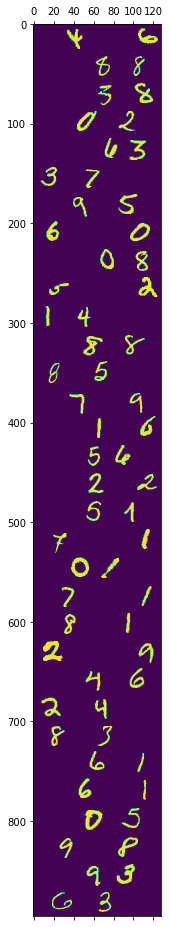

In [9]:
for batch in train_loader:
    data, targets = get_batch(batch, seq_len, digits_per_batch)

    plt.matshow((data.view(-1, data.shape[-1]) * mnist_std + mnist_mean).numpy())
    plt.show()
    break

### Average pooling

In [10]:
num_runs = 5
best_model = None
best_result = 1000000
results = []

for i in range(num_runs):
    features = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=(1,1)),
                             nn.BatchNorm2d(64),
                             nn.ReLU(),
                             nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),

                             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=(1,1)),
                             nn.BatchNorm2d(128),
                             nn.ReLU(),
                             nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),

                             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=(1,1)),
                             nn.BatchNorm2d(256),
                             nn.ReLU(),
                             nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),

                             nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=(0,1)),
                             nn.BatchNorm2d(512),
                             nn.ReLU()
                            )

    classifier = nn.Sequential(nn.Linear(512, 1028),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=1028, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=10, bias=True))

    conv = nn.Sequential(nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.AvgPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.AvgPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.AvgPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.AvgPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.AvgPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.AvgPool1d(kernel_size=2, stride=2))

    model = ConvMNIST(features, conv, classifier)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

    epochs = 30
    model, result = train_model(model, epochs, train_loader, test_loader, seq_len, digits_per_batch, optimizer, scheduler)
    
    if result < best_result:
        best_result = result
        best_model = model
        results.append(result)
        
model = best_model
print("Result over {} runs: {}".format(num_runs, torch.tensor(results).mean().item()))

| epoch   1 |   200/  938 batches | lr 0.00100 | ms/batch 82.52 | loss 64.37 |
| epoch   1 |   400/  938 batches | lr 0.00100 | ms/batch 79.99 | loss 26.51 |
| epoch   1 |   600/  938 batches | lr 0.00100 | ms/batch 78.62 | loss 21.16 |
| epoch   1 |   800/  938 batches | lr 0.00100 | ms/batch 73.52 | loss 16.28 |
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 77.94s | valid loss 18.58 |
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  938 batches | lr 0.00095 | ms/batch 75.53 | loss 12.05 |
| epoch   2 |   400/  938 batches | lr 0.00095 | ms/batch 76.08 | loss 11.87 |
| epoch   2 |   600/  938 batches | lr 0.00095 | ms/batch 76.41 | loss  9.91 |
| epoch   2 |   800/  938 batches | lr 0.00095 | ms/batch 74.87 | loss 10.82 |
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 94.39s | valid l

### Max pooling

In [10]:
num_runs = 5
best_model = None
best_result = 1000000
results = []

for i in range(num_runs):
    features = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(64),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(128),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(256),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=(0,1)),
                         nn.BatchNorm2d(512),
                         nn.ReLU()
                        )

    classifier = nn.Sequential(nn.Linear(512, 1028),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=1028, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=10, bias=True))

    conv = nn.Sequential(nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.MaxPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.MaxPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.MaxPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.MaxPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.MaxPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.MaxPool1d(kernel_size=2, stride=2))

    model = ConvMNIST(features, conv, classifier)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

    epochs = 30
    model, result = train_model(model, epochs, train_loader, test_loader, seq_len, digits_per_batch, optimizer, scheduler)
    
    if result < best_result:
        best_result = result
        best_model = model
        results.append(result)
        
model = best_model
print("Result over {} runs: {}".format(num_runs, torch.tensor(results).mean().item()))

| epoch   1 |   200/  938 batches | lr 0.00100 | ms/batch 84.14 | loss 79.52 |
| epoch   1 |   400/  938 batches | lr 0.00100 | ms/batch 81.70 | loss 31.08 |
| epoch   1 |   600/  938 batches | lr 0.00100 | ms/batch 80.45 | loss 21.66 |
| epoch   1 |   800/  938 batches | lr 0.00100 | ms/batch 81.11 | loss 17.56 |
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 82.71s | valid loss 25.48 |
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  938 batches | lr 0.00095 | ms/batch 81.98 | loss 13.01 |
| epoch   2 |   400/  938 batches | lr 0.00095 | ms/batch 82.79 | loss 11.19 |
| epoch   2 |   600/  938 batches | lr 0.00095 | ms/batch 82.73 | loss 10.64 |
| epoch   2 |   800/  938 batches | lr 0.00095 | ms/batch 82.76 | loss 10.36 |
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 83.58s | valid l

### Smart pooling

In [11]:
num_runs = 5
best_model = None
best_result = 1000000
results = []

for i in range(num_runs):
    features = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(64),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(128),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(256),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=(0,1)),
                         nn.BatchNorm2d(512),
                         nn.ReLU()
                        )

    classifier = nn.Sequential(nn.Linear(512, 1028),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=1028, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=10, bias=True))

    model = DoXTimes(Smartpool(divider, 0.3), classifier, features=features)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

    epochs = 30
    model, result = train_model(model, epochs, train_loader, test_loader, seq_len, digits_per_batch, optimizer, scheduler)
    
    if result < best_result:
        best_result = result
        best_model = model
        results.append(result)
        
model = best_model
print("Result over {} runs: {}".format(num_runs, torch.tensor(results).mean().item()))
    

| epoch   1 |   200/  938 batches | lr 0.00100 | ms/batch 149.99 | loss 44.63 |
| epoch   1 |   400/  938 batches | lr 0.00100 | ms/batch 149.22 | loss 11.12 |
| epoch   1 |   600/  938 batches | lr 0.00100 | ms/batch 149.19 | loss  9.61 |
| epoch   1 |   800/  938 batches | lr 0.00100 | ms/batch 149.19 | loss  7.76 |
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 150.06s | valid loss  9.96 |
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  938 batches | lr 0.00095 | ms/batch 149.88 | loss  6.61 |
| epoch   2 |   400/  938 batches | lr 0.00095 | ms/batch 149.15 | loss  7.10 |
| epoch   2 |   600/  938 batches | lr 0.00095 | ms/batch 149.22 | loss  6.19 |
| epoch   2 |   800/  938 batches | lr 0.00095 | ms/batch 149.15 | loss  5.76 |
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 150.07s

<Figure size 1200x800 with 0 Axes>

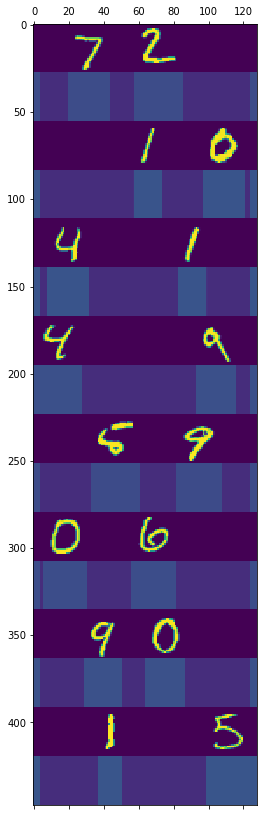

In [12]:
model.eval()
with torch.no_grad():
    for data in test_loader:
        data, targets = get_batch(data, seq_len, digits_per_batch)
        data = data.to(device)
        targets = targets.to(device)
        output = model.visualize(data)
        
        fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
        matrix = torch.empty((2*data.shape[0], data.shape[1], data.shape[2]), device=data.device)
        matrix[0::2] = data
        matrix[1::2] = output.view(output.shape[0], 1, output.shape[1]).repeat_interleave(data.shape[1], dim=1) * 10
        
        plt.matshow((matrix[:matrix.shape[0]//8,:,:].view(-1, data.shape[-1]) * mnist_std + mnist_mean).cpu().numpy())
        plt.show()
        break

### Average pooling - one layer

In [13]:
num_runs = 5
best_model = None
best_result = 1000000
results = []

for i in range(num_runs):
    features = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(64),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(128),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(256),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=(0,1)),
                         nn.BatchNorm2d(512),
                         nn.ReLU()
                        )

    classifier = nn.Sequential(nn.Linear(512, 1028),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=1028, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=10, bias=True))

    conv = nn.Sequential(nn.Conv1d(512, 512, kernel_size=64, stride=1, padding=32),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.AvgPool1d(kernel_size=64, stride=64))

    model = ConvMNIST(features, conv, classifier)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

    epochs = 30
    model, result = train_model(model, epochs, train_loader, test_loader, seq_len, digits_per_batch, optimizer, scheduler)
    
    if result < best_result:
        best_result = result
        best_model = model
        results.append(result)
        
model = best_model
print("Result over {} runs: {}".format(num_runs, torch.tensor(results).mean().item()))

| epoch   1 |   200/  938 batches | lr 0.00100 | ms/batch 122.11 | loss 52.53 |
| epoch   1 |   400/  938 batches | lr 0.00100 | ms/batch 121.81 | loss 20.15 |
| epoch   1 |   600/  938 batches | lr 0.00100 | ms/batch 121.81 | loss 16.17 |
| epoch   1 |   800/  938 batches | lr 0.00100 | ms/batch 121.85 | loss 13.46 |
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 118.91s | valid loss 16.21 |
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  938 batches | lr 0.00095 | ms/batch 122.54 | loss  9.93 |
| epoch   2 |   400/  938 batches | lr 0.00095 | ms/batch 122.83 | loss  9.60 |
| epoch   2 |   600/  938 batches | lr 0.00095 | ms/batch 122.95 | loss  9.75 |
| epoch   2 |   800/  938 batches | lr 0.00095 | ms/batch 123.07 | loss  8.88 |
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 119.77s

### Max pooling - one layer

In [14]:
num_runs = 5
best_model = None
best_result = 1000000
results = []

for i in range(num_runs):
    features = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(64),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(128),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(256),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=(0,1)),
                         nn.BatchNorm2d(512),
                         nn.ReLU()
                        )

    classifier = nn.Sequential(nn.Linear(512, 1028),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=1028, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=10, bias=True))

    conv = nn.Sequential(nn.Conv1d(512, 512, kernel_size=64, stride=1, padding=32),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.MaxPool1d(kernel_size=64, stride=64))

    model = ConvMNIST(features, conv, classifier)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

    epochs = 30
    model, result = train_model(model, epochs, train_loader, test_loader, seq_len, digits_per_batch, optimizer, scheduler)
    
    if result < best_result:
        best_result = result
        best_model = model
        results.append(result)
        
model = best_model
print("Result over {} runs: {}".format(num_runs, torch.tensor(results).mean().item()))

| epoch   1 |   200/  938 batches | lr 0.00100 | ms/batch 123.82 | loss 55.16 |
| epoch   1 |   400/  938 batches | lr 0.00100 | ms/batch 124.42 | loss 18.01 |
| epoch   1 |   600/  938 batches | lr 0.00100 | ms/batch 125.06 | loss 14.23 |
| epoch   1 |   800/  938 batches | lr 0.00100 | ms/batch 124.58 | loss 12.53 |
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 121.43s | valid loss  9.65 |
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  938 batches | lr 0.00095 | ms/batch 124.76 | loss  9.70 |
| epoch   2 |   400/  938 batches | lr 0.00095 | ms/batch 124.47 | loss  8.95 |
| epoch   2 |   600/  938 batches | lr 0.00095 | ms/batch 124.20 | loss  8.79 |
| epoch   2 |   800/  938 batches | lr 0.00095 | ms/batch 125.35 | loss  8.60 |
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 121.50s

## With gaussian noise

In [15]:
def get_batch(batch, seq_len, digits_per_batch):
    batch_size = batch[0].shape[0] // digits_per_batch
    width = batch[0].shape[-1]
    data = (torch.zeros(batch_size, batch[0].shape[2], seq_len) - mnist_mean) / mnist_std
    choices = torch.multinomial(torch.ones(batch_size, seq_len - (width - 1) * digits_per_batch), digits_per_batch)
    choices = choices.sort()[0] + torch.arange(digits_per_batch) * (width - 1)

    a = batch[0][torch.arange(batch[0].shape[0]),:,:].view(-1)
    b = torch.arange(batch_size).repeat_interleave(digits_per_batch * width * width)
    c = torch.arange(width).repeat_interleave(width).repeat(digits_per_batch * batch_size)
    d = (torch.arange(width).repeat(digits_per_batch * batch_size * width).view(digits_per_batch * batch_size, width, width) + choices.view(digits_per_batch * batch_size, 1, 1)).view(-1)
    data[b,c,d] = a
    batch[0] = data
    data += torch.randn_like(data)
    
    return data, batch[1]

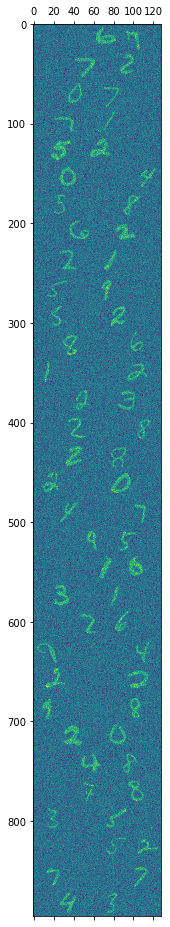

In [16]:
for batch in train_loader:
    data, targets = get_batch(batch, seq_len, digits_per_batch)
    
    plt.matshow((data.view(-1, data.shape[-1]) * mnist_std + mnist_mean).numpy())
    plt.show()
    break

### Average pooling

In [17]:
num_runs = 5
best_model = None
best_result = 1000000
results = []

for i in range(num_runs):
    features = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=(1,1)),
                             nn.BatchNorm2d(64),
                             nn.ReLU(),
                             nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),

                             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=(1,1)),
                             nn.BatchNorm2d(128),
                             nn.ReLU(),
                             nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),

                             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=(1,1)),
                             nn.BatchNorm2d(256),
                             nn.ReLU(),
                             nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),

                             nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=(0,1)),
                             nn.BatchNorm2d(512),
                             nn.ReLU()
                            )

    classifier = nn.Sequential(nn.Linear(512, 1028),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=1028, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=10, bias=True))

    conv = nn.Sequential(nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.AvgPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.AvgPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.AvgPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.AvgPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.AvgPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.AvgPool1d(kernel_size=2, stride=2))

    model = ConvMNIST(features, conv, classifier)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

    epochs = 30
    model, result = train_model(model, epochs, train_loader, test_loader, seq_len, digits_per_batch, optimizer, scheduler)
    
    if result < best_result:
        best_result = result
        best_model = model
        results.append(result)
        
model = best_model
print("Result over {} runs: {}".format(num_runs, torch.tensor(results).mean().item()))

| epoch   1 |   200/  938 batches | lr 0.00100 | ms/batch 71.71 | loss 76.41 |
| epoch   1 |   400/  938 batches | lr 0.00100 | ms/batch 71.30 | loss 30.88 |
| epoch   1 |   600/  938 batches | lr 0.00100 | ms/batch 71.32 | loss 21.27 |
| epoch   1 |   800/  938 batches | lr 0.00100 | ms/batch 85.47 | loss 18.46 |
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 77.66s | valid loss 25.67 |
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  938 batches | lr 0.00095 | ms/batch 83.71 | loss 15.61 |
| epoch   2 |   400/  938 batches | lr 0.00095 | ms/batch 83.86 | loss 13.37 |
| epoch   2 |   600/  938 batches | lr 0.00095 | ms/batch 86.86 | loss 12.41 |
| epoch   2 |   800/  938 batches | lr 0.00095 | ms/batch 81.42 | loss 12.60 |
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 84.67s | valid l

### Max pooling

In [18]:
num_runs = 5
best_model = None
best_result = 1000000
results = []

for i in range(num_runs):
    features = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(64),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(128),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(256),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=(0,1)),
                         nn.BatchNorm2d(512),
                         nn.ReLU()
                        )

    classifier = nn.Sequential(nn.Linear(512, 1028),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=1028, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=10, bias=True))

    conv = nn.Sequential(nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.MaxPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.MaxPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.MaxPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.MaxPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.MaxPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.MaxPool1d(kernel_size=2, stride=2))

    model = ConvMNIST(features, conv, classifier)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

    epochs = 30
    model, result = train_model(model, epochs, train_loader, test_loader, seq_len, digits_per_batch, optimizer, scheduler)
    
    if result < best_result:
        best_result = result
        best_model = model
        results.append(result)
        
model = best_model
print("Result over {} runs: {}".format(num_runs, torch.tensor(results).mean().item()))

| epoch   1 |   200/  938 batches | lr 0.00100 | ms/batch 72.08 | loss 86.32 |
| epoch   1 |   400/  938 batches | lr 0.00100 | ms/batch 73.16 | loss 36.04 |
| epoch   1 |   600/  938 batches | lr 0.00100 | ms/batch 72.00 | loss 22.79 |
| epoch   1 |   800/  938 batches | lr 0.00100 | ms/batch 72.66 | loss 20.05 |
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 75.38s | valid loss 24.19 |
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  938 batches | lr 0.00095 | ms/batch 82.91 | loss 15.21 |
| epoch   2 |   400/  938 batches | lr 0.00095 | ms/batch 82.50 | loss 14.74 |
| epoch   2 |   600/  938 batches | lr 0.00095 | ms/batch 72.67 | loss 13.10 |
| epoch   2 |   800/  938 batches | lr 0.00095 | ms/batch 80.22 | loss 11.86 |
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 81.06s | valid l

### Smart pooling

In [19]:
num_runs = 5
best_model = None
best_result = 1000000
results = []

for i in range(num_runs):
    features = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(64),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(128),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(256),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=(0,1)),
                         nn.BatchNorm2d(512),
                         nn.ReLU()
                        )

    classifier = nn.Sequential(nn.Linear(512, 1028),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=1028, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=10, bias=True))

    model = DoXTimes(Smartpool(divider, 0.3), classifier, features=features)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

    epochs = 30
    model, result = train_model(model, epochs, train_loader, test_loader, seq_len, digits_per_batch, optimizer, scheduler)
    
    if result < best_result:
        best_result = result
        best_model = model
        results.append(result)
        
model = best_model
print("Result over {} runs: {}".format(num_runs, torch.tensor(results).mean().item()))
    

| epoch   1 |   200/  938 batches | lr 0.00100 | ms/batch 192.00 | loss 44.57 |
| epoch   1 |   400/  938 batches | lr 0.00100 | ms/batch 192.64 | loss 15.32 |
| epoch   1 |   600/  938 batches | lr 0.00100 | ms/batch 198.13 | loss 13.64 |
| epoch   1 |   800/  938 batches | lr 0.00100 | ms/batch 180.46 | loss 11.43 |
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 191.13s | valid loss 16.64 |
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  938 batches | lr 0.00095 | ms/batch 197.32 | loss  9.36 |
| epoch   2 |   400/  938 batches | lr 0.00095 | ms/batch 198.43 | loss  9.60 |
| epoch   2 |   600/  938 batches | lr 0.00095 | ms/batch 193.15 | loss  8.87 |
| epoch   2 |   800/  938 batches | lr 0.00095 | ms/batch 201.25 | loss  8.35 |
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 198.87s

<Figure size 1200x800 with 0 Axes>

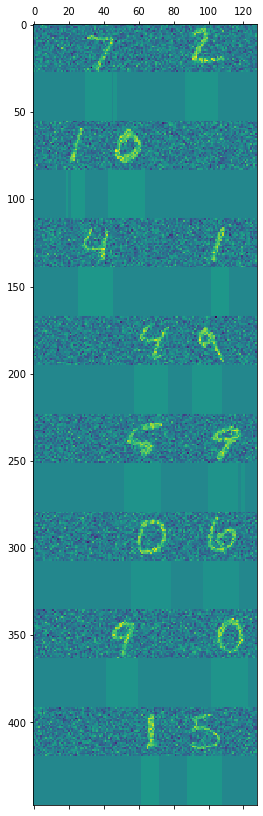

In [20]:
model.eval()
with torch.no_grad():
    for data in test_loader:
        data, targets = get_batch(data, seq_len, digits_per_batch)
        data = data.to(device)
        targets = targets.to(device)
        output = model.visualize(data)
        
        fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
        matrix = torch.empty((2*data.shape[0], data.shape[1], data.shape[2]), device=data.device)
        matrix[0::2] = data
        matrix[1::2] = output.view(output.shape[0], 1, output.shape[1]).repeat_interleave(data.shape[1], dim=1) * 10
        
        plt.matshow((matrix[:matrix.shape[0]//8,:,:].view(-1, data.shape[-1]) * mnist_std + mnist_mean).cpu().numpy())
        plt.show()
        break

### Average pooling - one layer

In [21]:
num_runs = 5
best_model = None
best_result = 1000000
results = []

for i in range(num_runs):
    features = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(64),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(128),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(256),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=(0,1)),
                         nn.BatchNorm2d(512),
                         nn.ReLU()
                        )

    classifier = nn.Sequential(nn.Linear(512, 1028),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=1028, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=10, bias=True))

    conv = nn.Sequential(nn.Conv1d(512, 512, kernel_size=64, stride=1, padding=32),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.AvgPool1d(kernel_size=64, stride=64))

    model = ConvMNIST(features, conv, classifier)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

    epochs = 30
    model, result = train_model(model, epochs, train_loader, test_loader, seq_len, digits_per_batch, optimizer, scheduler)
    
    if result < best_result:
        best_result = result
        best_model = model
        results.append(result)
        
model = best_model
print("Result over {} runs: {}".format(num_runs, torch.tensor(results).mean().item()))

| epoch   1 |   200/  938 batches | lr 0.00100 | ms/batch 125.20 | loss 54.70 |
| epoch   1 |   400/  938 batches | lr 0.00100 | ms/batch 124.82 | loss 22.90 |
| epoch   1 |   600/  938 batches | lr 0.00100 | ms/batch 125.54 | loss 19.74 |
| epoch   1 |   800/  938 batches | lr 0.00100 | ms/batch 124.98 | loss 16.48 |
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 122.49s | valid loss 24.62 |
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  938 batches | lr 0.00095 | ms/batch 125.96 | loss 13.94 |
| epoch   2 |   400/  938 batches | lr 0.00095 | ms/batch 127.50 | loss 13.62 |
| epoch   2 |   600/  938 batches | lr 0.00095 | ms/batch 125.84 | loss 11.53 |
| epoch   2 |   800/  938 batches | lr 0.00095 | ms/batch 128.52 | loss 10.62 |
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 123.82s

### Max pooling - one layer

In [22]:
num_runs = 5
best_model = None
best_result = 1000000
results = []

for i in range(num_runs):
    features = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(64),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(128),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(256),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=(0,1)),
                         nn.BatchNorm2d(512),
                         nn.ReLU()
                        )

    classifier = nn.Sequential(nn.Linear(512, 1028),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=1028, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=10, bias=True))

    conv = nn.Sequential(nn.Conv1d(512, 512, kernel_size=64, stride=1, padding=32),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.MaxPool1d(kernel_size=64, stride=64))

    model = ConvMNIST(features, conv, classifier)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

    epochs = 30
    model, result = train_model(model, epochs, train_loader, test_loader, seq_len, digits_per_batch, optimizer, scheduler)
    
    if result < best_result:
        best_result = result
        best_model = model
        results.append(result)
        
model = best_model
print("Result over {} runs: {}".format(num_runs, torch.tensor(results).mean().item()))

| epoch   1 |   200/  938 batches | lr 0.00100 | ms/batch 126.44 | loss 62.70 |
| epoch   1 |   400/  938 batches | lr 0.00100 | ms/batch 127.29 | loss 22.79 |
| epoch   1 |   600/  938 batches | lr 0.00100 | ms/batch 127.44 | loss 17.07 |
| epoch   1 |   800/  938 batches | lr 0.00100 | ms/batch 127.81 | loss 16.19 |
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 124.56s | valid loss 22.02 |
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  938 batches | lr 0.00095 | ms/batch 128.19 | loss 12.38 |
| epoch   2 |   400/  938 batches | lr 0.00095 | ms/batch 127.82 | loss 10.84 |
| epoch   2 |   600/  938 batches | lr 0.00095 | ms/batch 127.91 | loss 11.79 |
| epoch   2 |   800/  938 batches | lr 0.00095 | ms/batch 127.91 | loss 10.54 |
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 125.07s

## Gaussian noise patches

In [23]:
def get_batch(batch, seq_len, digits_per_batch):
    batch_size = batch[0].shape[0] // digits_per_batch
    width = batch[0].shape[-1]
    data = (torch.zeros(batch_size, batch[0].shape[2], seq_len) - mnist_mean) / mnist_std
    choices = torch.multinomial(torch.ones(batch_size, seq_len - (width - 1) * digits_per_batch), digits_per_batch)
    choices = choices.sort()[0] + torch.arange(digits_per_batch) * (width - 1)

    a = batch[0][torch.arange(batch[0].shape[0]),:,:].view(-1)
    b = torch.arange(batch_size).repeat_interleave(digits_per_batch * width * width)
    c = torch.arange(width).repeat_interleave(width).repeat(digits_per_batch * batch_size)
    d = (torch.arange(width).repeat(digits_per_batch * batch_size * width).view(digits_per_batch * batch_size, width, width) + choices.view(digits_per_batch * batch_size, 1, 1)).view(-1)
    data[b,c,d] = a
    
    # Adding N gaussian noise patches of size 20x20 each
    noise_patches = 3
    noise_width = 20
    choices = torch.multinomial(torch.ones(batch_size, seq_len - (noise_width - 1) * noise_patches), noise_patches)
    choices = choices.sort()[0] + torch.arange(noise_patches) * (noise_width - 1)

    a = torch.randn(batch_size * noise_patches * noise_width * noise_width)
    b = torch.arange(batch_size).repeat_interleave(noise_patches * noise_width * noise_width)
    c = torch.arange((width - noise_width) // 2, (width - noise_width) // 2 + noise_width).repeat_interleave(noise_width).repeat(noise_patches * batch_size)
    d = (torch.arange(noise_width).repeat(noise_patches * batch_size * noise_width).view(noise_patches * batch_size, noise_width, noise_width) + choices.view(noise_patches * batch_size, 1, 1)).view(-1)
    data[b,c,d] += a
    
    return data, batch[1]

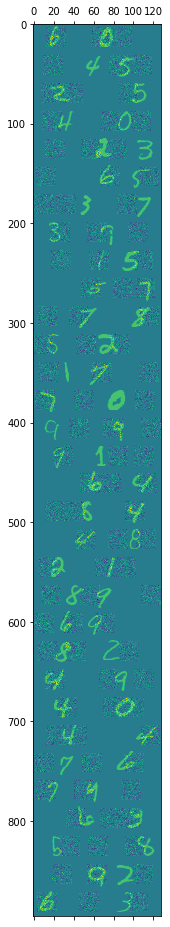

In [24]:
for batch in train_loader:
    data, targets = get_batch(batch, seq_len, digits_per_batch)

    plt.matshow((data.view(-1, data.shape[-1]) * mnist_std + mnist_mean).numpy())
    plt.show()
    break

### Average pooling

In [25]:
num_runs = 5
best_model = None
best_result = 1000000
results = []

for i in range(num_runs):
    features = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=(1,1)),
                             nn.BatchNorm2d(64),
                             nn.ReLU(),
                             nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),

                             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=(1,1)),
                             nn.BatchNorm2d(128),
                             nn.ReLU(),
                             nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),

                             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=(1,1)),
                             nn.BatchNorm2d(256),
                             nn.ReLU(),
                             nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),

                             nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=(0,1)),
                             nn.BatchNorm2d(512),
                             nn.ReLU()
                            )

    classifier = nn.Sequential(nn.Linear(512, 1028),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=1028, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=10, bias=True))

    conv = nn.Sequential(nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.AvgPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.AvgPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.AvgPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.AvgPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.AvgPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.AvgPool1d(kernel_size=2, stride=2))

    model = ConvMNIST(features, conv, classifier)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

    epochs = 30
    model, result = train_model(model, epochs, train_loader, test_loader, seq_len, digits_per_batch, optimizer, scheduler)
    
    if result < best_result:
        best_result = result
        best_model = model
        results.append(result)
        
model = best_model
print("Result over {} runs: {}".format(num_runs, torch.tensor(results).mean().item()))

| epoch   1 |   200/  938 batches | lr 0.00100 | ms/batch 69.36 | loss 73.51 |
| epoch   1 |   400/  938 batches | lr 0.00100 | ms/batch 69.02 | loss 30.81 |
| epoch   1 |   600/  938 batches | lr 0.00100 | ms/batch 69.20 | loss 20.69 |
| epoch   1 |   800/  938 batches | lr 0.00100 | ms/batch 69.32 | loss 18.68 |
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 69.95s | valid loss 29.82 |
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  938 batches | lr 0.00095 | ms/batch 69.48 | loss 14.34 |
| epoch   2 |   400/  938 batches | lr 0.00095 | ms/batch 74.37 | loss 13.69 |
| epoch   2 |   600/  938 batches | lr 0.00095 | ms/batch 69.12 | loss 11.75 |
| epoch   2 |   800/  938 batches | lr 0.00095 | ms/batch 69.11 | loss 10.73 |
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 71.00s | valid l

### Max pooling

In [26]:
num_runs = 5
best_model = None
best_result = 1000000
results = []

for i in range(num_runs):
    features = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(64),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(128),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(256),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=(0,1)),
                         nn.BatchNorm2d(512),
                         nn.ReLU()
                        )

    classifier = nn.Sequential(nn.Linear(512, 1028),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=1028, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=10, bias=True))

    conv = nn.Sequential(nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.MaxPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.MaxPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.MaxPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.MaxPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.MaxPool1d(kernel_size=2, stride=2),

                         nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.MaxPool1d(kernel_size=2, stride=2))

    model = ConvMNIST(features, conv, classifier)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

    epochs = 30
    model, result = train_model(model, epochs, train_loader, test_loader, seq_len, digits_per_batch, optimizer, scheduler)
    
    if result < best_result:
        best_result = result
        best_model = model
        results.append(result)
        
model = best_model
print("Result over {} runs: {}".format(num_runs, torch.tensor(results).mean().item()))

| epoch   1 |   200/  938 batches | lr 0.00100 | ms/batch 69.01 | loss 93.40 |
| epoch   1 |   400/  938 batches | lr 0.00100 | ms/batch 68.58 | loss 34.42 |
| epoch   1 |   600/  938 batches | lr 0.00100 | ms/batch 68.58 | loss 21.78 |
| epoch   1 |   800/  938 batches | lr 0.00100 | ms/batch 74.21 | loss 18.23 |
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 70.50s | valid loss 48.96 |
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  938 batches | lr 0.00095 | ms/batch 68.97 | loss 14.34 |
| epoch   2 |   400/  938 batches | lr 0.00095 | ms/batch 74.21 | loss 13.80 |
| epoch   2 |   600/  938 batches | lr 0.00095 | ms/batch 68.64 | loss 12.19 |
| epoch   2 |   800/  938 batches | lr 0.00095 | ms/batch 68.63 | loss 11.97 |
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 71.64s | valid l

### Smart pooling

In [27]:
num_runs = 5
best_model = None
best_result = 1000000
results = []

for i in range(num_runs):
    features = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(64),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(128),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(256),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=(0,1)),
                         nn.BatchNorm2d(512),
                         nn.ReLU()
                        )

    classifier = nn.Sequential(nn.Linear(512, 1028),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=1028, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=10, bias=True))

    model = DoXTimes(Smartpool(divider, 0.3), classifier, features=features)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

    epochs = 30
    model, result = train_model(model, epochs, train_loader, test_loader, seq_len, digits_per_batch, optimizer, scheduler)
    
    if result < best_result:
        best_result = result
        best_model = model
        results.append(result)
        
model = best_model
print("Result over {} runs: {}".format(num_runs, torch.tensor(results).mean().item()))
    

| epoch   1 |   200/  938 batches | lr 0.00100 | ms/batch 152.96 | loss 64.30 |
| epoch   1 |   400/  938 batches | lr 0.00100 | ms/batch 152.25 | loss 18.84 |
| epoch   1 |   600/  938 batches | lr 0.00100 | ms/batch 152.08 | loss 16.68 |
| epoch   1 |   800/  938 batches | lr 0.00100 | ms/batch 152.22 | loss 11.38 |
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 153.21s | valid loss 10.83 |
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  938 batches | lr 0.00095 | ms/batch 153.17 | loss 10.62 |
| epoch   2 |   400/  938 batches | lr 0.00095 | ms/batch 152.28 | loss 11.47 |
| epoch   2 |   600/  938 batches | lr 0.00095 | ms/batch 152.45 | loss  9.04 |
| epoch   2 |   800/  938 batches | lr 0.00095 | ms/batch 152.29 | loss  7.55 |
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 154.56s

<Figure size 1200x800 with 0 Axes>

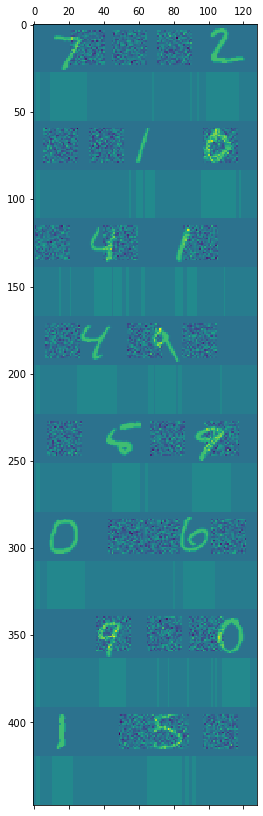

In [28]:
model.eval()
with torch.no_grad():
    for data in test_loader:
        data, targets = get_batch(data, seq_len, digits_per_batch)
        data = data.to(device)
        targets = targets.to(device)
        output = model.visualize(data)
        
        fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
        matrix = torch.empty((2*data.shape[0], data.shape[1], data.shape[2]), device=data.device)
        matrix[0::2] = data
        matrix[1::2] = output.view(output.shape[0], 1, output.shape[1]).repeat_interleave(data.shape[1], dim=1) * 10
        
        plt.matshow((matrix[:matrix.shape[0]//8,:,:].view(-1, data.shape[-1]) * mnist_std + mnist_mean).cpu().numpy())
        plt.show()
        break

### Average pooling - one layer

In [29]:
num_runs = 5
best_model = None
best_result = 1000000
results = []

for i in range(num_runs):
    features = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(64),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(128),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(256),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=(0,1)),
                         nn.BatchNorm2d(512),
                         nn.ReLU()
                        )

    classifier = nn.Sequential(nn.Linear(512, 1028),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=1028, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=10, bias=True))

    conv = nn.Sequential(nn.Conv1d(512, 512, kernel_size=64, stride=1, padding=32),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.AvgPool1d(kernel_size=64, stride=64))

    model = ConvMNIST(features, conv, classifier)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

    epochs = 30
    model, result = train_model(model, epochs, train_loader, test_loader, seq_len, digits_per_batch, optimizer, scheduler)
    
    if result < best_result:
        best_result = result
        best_model = model
        results.append(result)
        
model = best_model
print("Result over {} runs: {}".format(num_runs, torch.tensor(results).mean().item()))

| epoch   1 |   200/  938 batches | lr 0.00100 | ms/batch 121.97 | loss 61.86 |
| epoch   1 |   400/  938 batches | lr 0.00100 | ms/batch 121.59 | loss 25.64 |
| epoch   1 |   600/  938 batches | lr 0.00100 | ms/batch 121.81 | loss 18.93 |
| epoch   1 |   800/  938 batches | lr 0.00100 | ms/batch 121.93 | loss 16.15 |
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 119.12s | valid loss 19.44 |
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  938 batches | lr 0.00095 | ms/batch 123.15 | loss 14.00 |
| epoch   2 |   400/  938 batches | lr 0.00095 | ms/batch 123.05 | loss 12.89 |
| epoch   2 |   600/  938 batches | lr 0.00095 | ms/batch 123.40 | loss 11.29 |
| epoch   2 |   800/  938 batches | lr 0.00095 | ms/batch 123.53 | loss 10.65 |
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 120.38s

### Max pooling - one layer

In [30]:
num_runs = 5
best_model = None
best_result = 1000000
results = []

for i in range(num_runs):
    features = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(64),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(128),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(256),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=(0,1)),
                         nn.BatchNorm2d(512),
                         nn.ReLU()
                        )

    classifier = nn.Sequential(nn.Linear(512, 1028),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=1028, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=10, bias=True))

    conv = nn.Sequential(nn.Conv1d(512, 512, kernel_size=64, stride=1, padding=32),
                         nn.BatchNorm1d(512),
                         nn.ReLU(),
                         nn.MaxPool1d(kernel_size=64, stride=64))

    model = ConvMNIST(features, conv, classifier)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

    epochs = 30
    model, result = train_model(model, epochs, train_loader, test_loader, seq_len, digits_per_batch, optimizer, scheduler)
    
    if result < best_result:
        best_result = result
        best_model = model
        results.append(result)
        
model = best_model
print("Result over {} runs: {}".format(num_runs, torch.tensor(results).mean().item()))

| epoch   1 |   200/  938 batches | lr 0.00100 | ms/batch 122.74 | loss 67.42 |
| epoch   1 |   400/  938 batches | lr 0.00100 | ms/batch 123.62 | loss 22.29 |
| epoch   1 |   600/  938 batches | lr 0.00100 | ms/batch 128.29 | loss 17.70 |
| epoch   1 |   800/  938 batches | lr 0.00100 | ms/batch 124.56 | loss 15.63 |
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 122.03s | valid loss 18.96 |
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  938 batches | lr 0.00095 | ms/batch 125.78 | loss 12.29 |
| epoch   2 |   400/  938 batches | lr 0.00095 | ms/batch 124.72 | loss 11.52 |
| epoch   2 |   600/  938 batches | lr 0.00095 | ms/batch 124.94 | loss 10.99 |
| epoch   2 |   800/  938 batches | lr 0.00095 | ms/batch 125.43 | loss 10.20 |
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 122.21s

## Results

Average of 5 runs


In [4]:
import pandas as pd
pd.read_csv("mnist2digits_results.csv")

,Data,Avg Pool,Max Pool,Smart Pool,Avg Pool (1 layer),Max Pool (1 layer)
0,No gaussian noise,6.499177,6.899555,5.189909,5.386036,5.667505
1,With gaussian noise,5.994575,6.298229,6.170612,6.206100,5.279452
2,Gaussian noise patches,5.778070,5.668732,4.473104,5.207829,4.923705


# Experimental

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms, datasets

import time
import math
import matplotlib.pyplot as plt
import numpy as np
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [18]:
class ConvMNIST(nn.Module):
    def __init__(
        self,
        features,
        conv,
        classifier
    ):
        super().__init__()
        self.features = features
        self.conv = conv
        self.classifier = classifier

    def forward(self, x):
        x = x.unsqueeze(1)
        #print('before features:', x.shape)
        x = self.features(x)
        x = x.squeeze(2)
        #print('after features:', x.shape)
        x = self.conv(x)
        x = x.squeeze(2).transpose(1,2)
        #print('after sq and tr', x.shape)
        x = self.classifier(x)
        #print('after classification:', x.shape)
        x = x.view(x.shape[0] * x.shape[1], -1)
        #print('after x view', x.shape)
        return x


In [55]:
class Smartpool(nn.Module):
    def __init__(
        self,
        factor,
        search_perc,
        entire_batch=False,
        mlp2=False
    ):
        """Smart pooling algorithm

        Args:
            factor: factor by which the sequence's length will be reduced
            search_perc: percentage of length of sequence after smartpooling to search for border. Ideally the border is located somewhere in +-search_perc
        """
        super().__init__()

        self.search_perc = search_perc
        self.factor = factor
        self.entire_batch = entire_batch
        self.register_buffer("filters", torch.FloatTensor([[[[-1,1],[1,-1]]]]), persistent=False)
        self.mlp = nn.Sequential(
            nn.Linear(512, 2048),
            nn.Dropout(0.1),
            nn.GELU(),
            nn.Linear(2048, 2048),
            nn.Dropout(0.1),
            nn.GELU(),
            nn.Linear(2048, 1),
            nn.Sigmoid())
        
        if mlp2 == True:
            self.mlp2 = nn.Sequential(
                nn.Linear(2, 256),
                nn.Dropout(0.1),
                nn.GELU(),
                nn.Linear(256,512),
                nn.Dropout(0.1),
                nn.GELU(),
                nn.Linear(512,256),
                nn.Dropout(0.1),
                nn.GELU(),
                nn.Linear(256,1))
        else:
            self.mlp2 = None
            
        self.visualization = False

    def warp(self, X, new_lens):
        #print(f'X shape = {X.shape}, new_lens shape = {new_lens.shape}')
        new_lens_cs = new_lens.cumsum(1)
        #print(f'new_lens_cs shape = {new_lens_cs.shape}')
        #print(f'new_lens_cs ends = {new_lens_cs[:, -1]}')
        # This really searches for the low boundary of each new pixel
        #pixel_contributions = new_lens_cs.view(1, -1, 1) - torch.arange(torch.round(new_lens_cs[0, -1]).item(), device=X.device).view(1, 1, -1)
        pixel_contributions = new_lens_cs.view(new_lens_cs.shape[0], -1, 1) - torch.arange(torch.round(new_lens_cs[0, -1]).item(), device=X.device).view(1, 1, -1)
        #print(f'pixel shape = {pixel_contributions.shape}')
        #print(f'pixel shape[0,:,:] = {pixel_contributions[0,:,:]}')
        pixel_contributions = pixel_contributions.view(X.size(0), X.size(1), pixel_contributions.size(2))
        #print(f'pixel shape2 = {pixel_contributions.shape}')
        # Zero out the negative contributions, i.e. pixels which come before each row                              
        pixel_contributions = torch.max(torch.tensor(0.0, device=X.device), pixel_contributions)       
        #print(f'pixel shape3 = {pixel_contributions.shape}')
        
        # # This contains the cumulated pixel lengths for all pixels in each 
        # pixel_contributions
    
        pixel_contributions = pixel_contributions.unsqueeze(1)
        #print(f'pixel shape4 = {pixel_contributions.shape}')
        interp_weights = F.conv2d(pixel_contributions, self.filters, padding=1)
        #print(f'interp shape = {interp_weights.shape}')
        interp_weights = interp_weights[:,:,:-1,1:] # Removing padding
        #print(f'interp shape2 = {interp_weights.shape}')
        interp_weights = interp_weights.squeeze(1)
        #print(f'interp shape3 = {interp_weights.shape}')

        # # Each column corresponds to a new element. Its values are the 
        # # weights associated with the original data.
        # interp_weights

        interp_weights = interp_weights.transpose(1, 2)
        #print(f'interp shape4 = {interp_weights.shape}')
        Xnew = interp_weights @ X
        #print(f'Xnew shape = {Xnew.shape}')
        return Xnew, interp_weights

    def nonzero_interval_length(self, x, dim):
        nonz = (x > 0)
        _, low = ((nonz.cumsum(dim) == 1) & nonz).max(dim, keepdim=True)
        rev_cumsum = nonz.long().flip(dim).cumsum(dim).flip(dim)
        _, high = ((rev_cumsum == 1) & nonz).max(dim, keepdim=True)
        
        return high - low + 1

    def forward(self, features):
        #print('features shape', features.shape)
        B,T,C = features.size()
        #print(f'features shape: {features.shape}')

        padding_mask = torch.zeros(B,T, dtype=torch.bool, device=features.device)
        padding_per_batch = (padding_mask > 0).sum(1)
        total_T = padding_mask.numel() - padding_per_batch.sum() if self.entire_batch else (T - padding_per_batch).view(-1, 1)
        #print(f'total_T shape: {total_T.shape}')
        #### B*T ^^^

        
        #print(f'features shape2: {features.shape}')
        new_lens = self.mlp(features).view(B,T)
        #print(f'new_lens shape: {new_lens.shape}')
        new_lens = new_lens / new_lens.sum(1, keepdim=True) * (total_T / self.factor) # Reducing the original length T by some factor
        #print(f'new_lens shape2: {new_lens.shape}')
        
        
        # MLP test
        #new_lens = self.mlp(features.view(B*T,C)).view(1,-1)
        #new_lens = new_lens / new_lens.sum(1, keepdim=True) * (total_T / self.factor) # Reducing the original length T by some factor
        
        if self.visualization:
            return new_lens
       
        features, interp_weights = self.warp(features, new_lens)
        
        if self.mlp2 is not None:
            features = self.mlp2(features)

        return features
    
    def set_visualization(self, value):
        self.visualization = value
        

class DoXTimes(nn.Module):
    def __init__(self, model, classifier, features=None):
        super().__init__()
        self.model = model
        self.classifier = classifier
        self.features = features
        
    def forward(self, x):
        #print('1', x.shape)
        
        #print('2', x.shape)
        if self.features is not None:

            x = x.unsqueeze(1)
            x = self.features(x)
            x = x.squeeze(2)
                
        #print('3', x.shape)
        x = x.transpose(1,2)
        B = x.shape[0]
        #x = torch.cat([self.model(x[i].unsqueeze(0)) for i in range(B)])
        x = self.model(x)
        #print('4', x.shape)
        x = self.classifier(x)
        x = x.view(B * x.shape[1], -1)
        return x
    
    def visualize(self, x):
        self.model.set_visualization(True)
        if self.features is not None:
            x = x.unsqueeze(1)
            x = self.features(x)
            x = x.squeeze(2)
                
        #print('3', x.shape)
        x = x.transpose(1,2)
        B = x.shape[0]
        #x = torch.cat([self.model(x[i].unsqueeze(0)) for i in range(B)])
        x = self.model(x)
        
        x = x.squeeze(1)
        self.model.set_visualization(False)
        return x

In [29]:
seq_len = 128
digits_per_batch = 2
divider = seq_len // digits_per_batch

dataset_root = "."
mnist_mean = 0.1307
mnist_std = 0.3081
batch_size_train = 32
batch_size_test = 64

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(dataset_root, train=True, download=True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(
                                 (mnist_mean,), (mnist_std,))
                             ])),
    batch_size=digits_per_batch * batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(dataset_root, train=False, download=True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(
                                 (mnist_mean,), (mnist_std,))
                             ])),
    batch_size=digits_per_batch * batch_size_test, shuffle=False)

In [30]:
def train(model, epoch, optimizer, scheduler, loader, seq_len, digits_per_batch):
    model.train()
    total_loss = 0.
    start_time = time.time()

    for batch, data in enumerate(loader):
        data, targets = get_batch(data, seq_len, digits_per_batch)
        data = data.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        loss = F.cross_entropy(output, targets, reduction="sum")
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.5f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} |'.format(
                    epoch, batch, len(loader), scheduler.get_last_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()

In [31]:
def evaluate(model, loader, seq_len, digits_per_batch):
    model.eval()
    total_loss = 0.
    seed = torch.seed()
    torch.manual_seed(0)
    with torch.no_grad():
        for data in loader:
            data, targets = get_batch(data, seq_len, digits_per_batch)
            data = data.to(device)
            targets = targets.to(device)
            output = model(data)
            total_loss += F.cross_entropy(output, targets, reduction="sum").item()
    torch.manual_seed(seed)
    return total_loss / len(loader)

In [32]:
def train_model(model, epochs, train_loader, test_loader, seq_len, digits_per_batch, optimizer, scheduler):
    best_val_loss = float("inf")
    best_model = None
    patience_expansion = 1.5
    
    epoch = 1
    while epoch <= epochs:
        epoch_start_time = time.time()
        train(model, epoch, optimizer, scheduler, train_loader, seq_len, digits_per_batch)
        val_loss = evaluate(model, test_loader, seq_len, digits_per_batch)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} |'.format(
            epoch, (time.time() - epoch_start_time),val_loss))
        print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            epochs = int(np.maximum(epochs, epoch * patience_expansion + 1))

        scheduler.step()
        epoch += 1


    test_loss = evaluate(best_model, test_loader, seq_len, digits_per_batch)
    print('=' * 89)
    print('| End of training | test loss {:5.2f} |'.format(
        test_loss))
    print('=' * 89)

    return best_model, test_loss

## No gaussian noise

In [33]:
def get_batch(batch, seq_len, digits_per_batch):
    batch_size = batch[0].shape[0] // digits_per_batch
    width = batch[0].shape[-1]
    data = (torch.zeros(batch_size, batch[0].shape[2], seq_len) - mnist_mean) / mnist_std
    choices = torch.multinomial(torch.ones(batch_size, seq_len - (width - 1) * digits_per_batch), digits_per_batch)
    choices = choices.sort()[0] + torch.arange(digits_per_batch) * (width - 1)

    a = batch[0][torch.arange(batch[0].shape[0]),:,:].view(-1)
    b = torch.arange(batch_size).repeat_interleave(digits_per_batch * width * width)
    c = torch.arange(width).repeat_interleave(width).repeat(digits_per_batch * batch_size)
    d = (torch.arange(width).repeat(digits_per_batch * batch_size * width).view(digits_per_batch * batch_size, width, width) + choices.view(digits_per_batch * batch_size, 1, 1)).view(-1)
    data[b,c,d] = a
    batch[0] = data
    
    return data, batch[1]

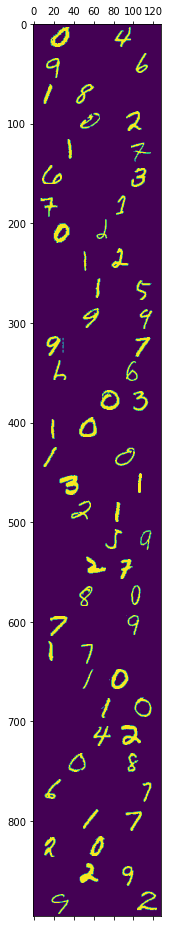

In [34]:
for batch in train_loader:
    data, targets = get_batch(batch, seq_len, digits_per_batch)

    plt.matshow((data.view(-1, data.shape[-1]) * mnist_std + mnist_mean).numpy())
    plt.show()
    break

### Smart pooling

In [ ]:
num_runs = 5
best_model = None
best_result = 1000000
results = []

for i in range(num_runs):
    features = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(64),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(128),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=(1,1)),
                         nn.BatchNorm2d(256),
                         nn.ReLU(),
                         nn.AvgPool2d(kernel_size=(2,1), stride=(2,1), padding=(0,0)),
                         
                         nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=(0,1)),
                         nn.BatchNorm2d(512),
                         nn.ReLU()
                        )

    classifier = nn.Sequential(nn.Linear(512, 1028),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=1028, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=1028, out_features=10, bias=True))

    model = DoXTimes(Smartpool(divider, 0.3, entire_batch=False), classifier, features=features)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

    epochs = 30
    model, result = train_model(model, epochs, train_loader, test_loader, seq_len, digits_per_batch, optimizer, scheduler)
    
    if result < best_result:
        best_result = result
        best_model = model
        results.append(result)
        
model = best_model
print("Result over {} runs: {}".format(num_runs, torch.tensor(results).mean().item()))
    

| epoch   1 |   200/  938 batches | lr 0.00100 | ms/batch 75.56 | loss 39.50 |
| epoch   1 |   400/  938 batches | lr 0.00100 | ms/batch 75.31 | loss 20.90 |
| epoch   1 |   600/  938 batches | lr 0.00100 | ms/batch 75.27 | loss 12.93 |
| epoch   1 |   800/  938 batches | lr 0.00100 | ms/batch 75.40 | loss  7.85 |
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 76.23s | valid loss 10.77 |
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  938 batches | lr 0.00095 | ms/batch 78.01 | loss  7.56 |
| epoch   2 |   400/  938 batches | lr 0.00095 | ms/batch 77.74 | loss  6.07 |
| epoch   2 |   600/  938 batches | lr 0.00095 | ms/batch 77.78 | loss  6.11 |
| epoch   2 |   800/  938 batches | lr 0.00095 | ms/batch 77.88 | loss  5.98 |
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 78.30s | valid l

<Figure size 1200x800 with 0 Axes>

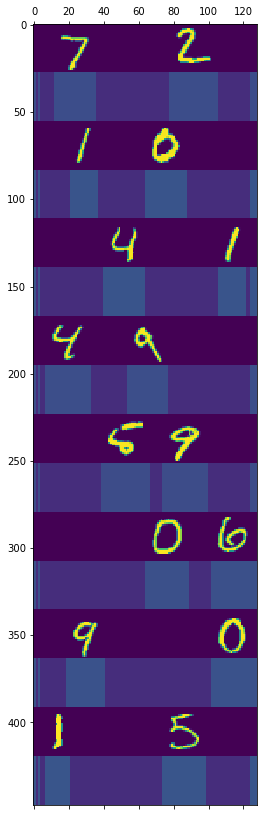

In [57]:
model.eval()
with torch.no_grad():
    for data in test_loader:
        data, targets = get_batch(data, seq_len, digits_per_batch)
        data = data.to(device)
        targets = targets.to(device)
        output = model.visualize(data)
        
        fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
        matrix = torch.empty((2*data.shape[0], data.shape[1], data.shape[2]), device=data.device)
        matrix[0::2] = data
        matrix[1::2] = output.view(output.shape[0], 1, output.shape[1]).repeat_interleave(data.shape[1], dim=1) * 10
        
        plt.matshow((matrix[:matrix.shape[0]//8,:,:].view(-1, data.shape[-1]) * mnist_std + mnist_mean).cpu().numpy())
        plt.show()
        break